#0) Imports and Installs

In [ ]:
!pip install yfinance

In [ ]:
# IMPORTS
import numpy as np
import pandas as pd

#Fin Data Sources
import yfinance as yf
import pandas_datareader as pdr

#Data viz
import plotly.graph_objs as go
import plotly.express as px

import time
from datetime import date

# for graphs
import matplotlib.pyplot as plt


# 1) [Code Snippet 1] IPOs data from Web

* learn dataframes "stacking" (UNION ALL)
* learn about type casting
* generate new columns (simple and with function)


In [ ]:
import pandas as pd
import requests

headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3',
}

url = "https://stockanalysis.com/ipos/2023/"
response = requests.get(url, headers=headers)

ipo_dfs = pd.read_html(response.text)

In [ ]:
ipos_2023 = ipo_dfs[0]
ipos_2023.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154 entries, 0 to 153
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   IPO Date      154 non-null    object
 1   Symbol        154 non-null    object
 2   Company Name  154 non-null    object
 3   IPO Price     154 non-null    object
 4   Current       154 non-null    object
 5   Return        154 non-null    object
dtypes: object(6)
memory usage: 7.3+ KB


In [ ]:
url = "https://stockanalysis.com/ipos/2024/"
response = requests.get(url, headers=headers)

ipo_dfs = pd.read_html(response.text)

In [ ]:
ipos_2024 = ipo_dfs[0]
ipos_2024.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   IPO Date      59 non-null     object
 1   Symbol        59 non-null     object
 2   Company Name  59 non-null     object
 3   IPO Price     59 non-null     object
 4   Current       59 non-null     object
 5   Return        59 non-null     object
dtypes: object(6)
memory usage: 2.9+ KB


In [ ]:
# "stacking dataframes"
# pd.concat() is used to concatenate the DataFrames vertically.
# The ignore_index=True parameter ensures that the resulting DataFrame has a new index,
# ignoring the original indices of the input DataFrames.
# The stacked_df now contains the concatenated DataFrame.
stacked_ipos_df = pd.concat([ipos_2024, ipos_2023], ignore_index=True)

In [ ]:
stacked_ipos_df.head(1)

,IPO Date,Symbol,Company Name,IPO Price,Current,Return
0,"Apr 23, 2024",NCI,Neo-Concept International Group Holdings Limited,-,$2.34,-


In [ ]:
# Need to convert everything to a proper type (date, str, int, float, etc.)
stacked_ipos_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213 entries, 0 to 212
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   IPO Date      213 non-null    object
 1   Symbol        213 non-null    object
 2   Company Name  213 non-null    object
 3   IPO Price     213 non-null    object
 4   Current       213 non-null    object
 5   Return        213 non-null    object
dtypes: object(6)
memory usage: 10.1+ KB


In [ ]:
# convert to datetime
stacked_ipos_df['IPO Date'] = pd.to_datetime(stacked_ipos_df['IPO Date'])

In [ ]:
# Problem --> not always the columns are filled
missing_prices_df = stacked_ipos_df[stacked_ipos_df['IPO Price'].astype(str).str.find('-') >= 0]
missing_prices_df

,IPO Date,Symbol,Company Name,IPO Price,Current,Return
0,2024-04-23,NCI,Neo-Concept International Group Holdings Limited,-,$2.34,-


In [ ]:
# it has some missing values --> use defensive errors='coerce' (if don't have time to crack into the data errors)
#     : pd.to_numeric() function call, which will convert problematic values to NaN.
#     otherwise you'll get a ValueError: Unable to parse string "-" at position 9
stacked_ipos_df['IPO Price'] = pd.to_numeric(stacked_ipos_df['IPO Price'].str.replace('$', ''), errors='coerce')
# not sure why, but need to call it again to transform 'object' to 'float64'
stacked_ipos_df['IPO Price'] = pd.to_numeric(stacked_ipos_df['IPO Price'])

In [ ]:
# Convert "Current" column
stacked_ipos_df['Current'] = pd.to_numeric(stacked_ipos_df['Current'].str.replace('$', ''), errors='coerce')

# Convert 'Return' to numeric format (percentage)
stacked_ipos_df['Return'] = pd.to_numeric(stacked_ipos_df['Return'].str.replace('%', ''), errors='coerce') / 100

In [ ]:
# Correctly applied transformations with 'defensive' techniques, but now not all are non-null
stacked_ipos_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213 entries, 0 to 212
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   IPO Date      213 non-null    datetime64[ns]
 1   Symbol        213 non-null    object        
 2   Company Name  213 non-null    object        
 3   IPO Price     212 non-null    float64       
 4   Current       213 non-null    float64       
 5   Return        210 non-null    float64       
dtypes: datetime64[ns](1), float64(3), object(2)
memory usage: 10.1+ KB


In [ ]:
# simple way of checking NULLs
# (you need to understand how vector operations work .isnull() and calls chaining .isnull().sum())
stacked_ipos_df.isnull().sum()

IPO Date        0
Symbol          0
Company Name    0
IPO Price       1
Current         0
Return          3
dtype: int64

In [ ]:
# Do you want to leave the record or not?
stacked_ipos_df[stacked_ipos_df.Return.isnull()]

,IPO Date,Symbol,Company Name,IPO Price,Current,Return
0,2024-04-23,NCI,Neo-Concept International Group Holdings Limited,NaN,2.34,NaN
7,2024-04-18,MTEN,Mingteng International Corporation Inc.,4.0,4.00,NaN
8,2024-04-17,JUNE,Junee Limited,4.0,4.00,NaN


In [ ]:
# now you can operate with columns as a numeric type
stacked_ipos_df['IPO Price'].mean()

10.849669811320755

In [ ]:
# generate a new field -- SIMPLE calculation (no function needed)
stacked_ipos_df['Price Increase'] = stacked_ipos_df['Current'] - stacked_ipos_df['IPO Price']

In [ ]:
stacked_ipos_df.head(1)

,IPO Date,Symbol,Company Name,IPO Price,Current,Return,Price Increase
0,2024-04-23,NCI,Neo-Concept International Group Holdings Limited,NaN,2.34,NaN,NaN


In [ ]:
# Descriptive Analytics of a dataset
stacked_ipos_df.describe()

,IPO Date,IPO Price,Current,Return,Price Increase
count,213,212.000000,213.000000,210.000000,212.000000
mean,2023-09-02 17:27:53.239436544,10.849670,10.654695,-0.205207,-0.155755
min,2023-01-13 00:00:00,2.500000,0.000000,-0.999600,-19.530000
25%,2023-04-20 00:00:00,4.000000,1.230000,-0.736850,-3.730000
50%,2023-09-12 00:00:00,7.500000,5.330000,-0.245800,-1.915000
75%,2024-01-19 00:00:00,12.625000,10.830000,0.057050,0.575000
max,2024-04-23 00:00:00,92.000000,116.200000,4.970000,48.880000
std,NaN,11.180939,16.479009,0.701169,8.402947


In [ ]:
# some visualisation: bar chart using Plotly Express
import plotly.express as px

# Truncate to the first day in the month - for Bar names
stacked_ipos_df['Date_monthly'] = stacked_ipos_df['IPO Date'].dt.to_period('M').dt.to_timestamp()

# Count the number of deals for each month and year
monthly_deals = stacked_ipos_df['Date_monthly'].value_counts().reset_index().sort_values(by='Date_monthly')
monthly_deals.columns = ['Date_monthly', 'Number of Deals']

# Plotting the bar chart using Plotly Express
fig = px.bar(monthly_deals,
             x='Date_monthly',
             y='Number of Deals',
             labels={'Month_Year': 'Month and Year', 'Number of Deals': 'Number of Deals'},
             title='Number of IPO Deals per Month and Year',
             text='Number of Deals'
             )
fig.update_traces(textposition='outside', # Position the text outside the bars
                  textfont=dict(color='black',size=14), # Adjust the font size of the text
                  )
fig.update_layout(title_x=0.5) # Center the title

fig.show()

In [ ]:
# To be used for home assignment: 'You can notice a bump in the price after the IPO? And after that the price goes down
# You're asked to design a simple strategy to buy and hold for X days (at 'Adj.Close' price, no fees)
# Find an optimal X between 1 and 30, that delivers you a MAX mean return on ALL 2023 IPOs?
# Write down the answer X (a number between 1 and 30)

# What is the distribution of other returns 25-50-75% quantiles? Compare mean and median returns for 2023 (median may be more robust),
  # are you losing money in 25% cases (if 25% quantile returns is < 0)
  # Try the same X for all deals in 2024.  How the mean return in 2024 (out of sample data) is different from 2023 data?

# REDDIT - recent IPO
# https://finance.yahoo.com/quote/RDDT/
reddit = yf.download(tickers = "RDDT",
                     period = "max",
                     interval = "1d")

reddit.tail()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-04-19,40.570000,43.830002,40.169998,40.880001,40.880001,2528100
2024-04-22,40.880001,42.570000,40.509998,42.040001,42.040001,1486400
2024-04-23,42.070000,44.060001,41.821999,42.820000,42.820000,1956500
2024-04-24,42.660000,43.970001,42.450001,43.150002,43.150002,1382400
2024-04-25,41.639999,42.040001,40.959999,41.290001,41.290001,296335


<Axes: title={'center': "Reddit's (RDDT) price after the IPO"}, xlabel='Date'>

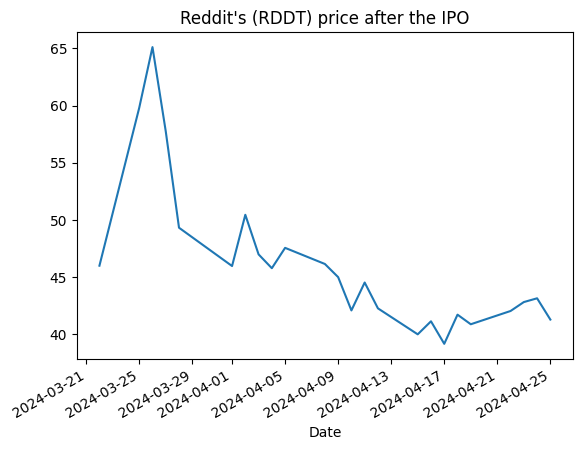

In [ ]:
reddit['Adj Close'].plot.line(title='Reddit\'s (RDDT) price after the IPO')

#2) OHLCV data transformations

## 2.1 [Code Snippet 2] Time series for OHLCV

In [ ]:
nvo_df = yf.download(tickers = "NVO",
                     period = "max",
                     interval = "1d")

[*********************100%%**********************]  1 of 1 completed


In [ ]:
# big plus of an API's data: good typing from the box!
# notice DatetimeIndex - it is a recognised date
nvo_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10838 entries, 1981-04-30 to 2024-04-25
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       10838 non-null  float64
 1   High       10838 non-null  float64
 2   Low        10838 non-null  float64
 3   Close      10838 non-null  float64
 4   Adj Close  10838 non-null  float64
 5   Volume     10838 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 592.7 KB


In [ ]:
nvo_df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-04-19,123.480003,124.540001,122.459999,122.709999,122.709999,5181100
2024-04-22,122.589996,126.250000,122.570000,125.260002,125.260002,3798300
2024-04-23,126.570000,128.759995,126.339996,128.639999,128.639999,3703600
2024-04-24,127.160004,127.320000,125.349998,126.160004,126.160004,3137500
2024-04-25,123.690002,124.470001,123.209999,123.940002,123.940002,785105


In [ ]:
# filter on date (index)
nvo_df_filtered_from_2020 = nvo_df[nvo_df.index>='2020-01-01']
nvo_df_filtered_from_2024 = nvo_df[nvo_df.index>='2024-01-01']

<Axes: title={'center': 'Novo Nordisk A/S (NVO) price daily'}, xlabel='Date'>

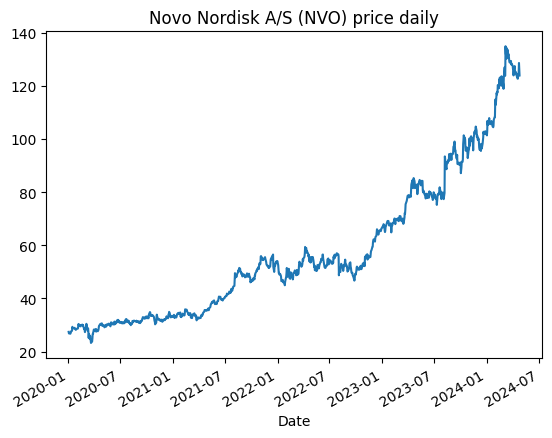

In [ ]:
# Chaining: select one column, draw a plot, of a type line
nvo_df_filtered_from_2020['Adj Close'].plot.line(title='Novo Nordisk A/S (NVO) price daily')

In [ ]:
# generating new fields (using DateTime features):

nvo_df['Ticker'] = 'NVO'
nvo_df['Year']= nvo_df.index.year
nvo_df['Month'] = nvo_df.index.month
nvo_df['Weekday'] = nvo_df.index.weekday
nvo_df['Date'] = nvo_df.index.date # to be used in joins

In [ ]:
nvo_df.tail()

,Open,High,Low,Close,Adj Close,Volume,Ticker,Year,Month,Weekday,Date
Date,,,,,,,,,,,
2024-04-19,123.480003,124.540001,122.459999,122.709999,122.709999,5181100,NVO,2024,4,4,2024-04-19
2024-04-22,122.589996,126.250000,122.570000,125.260002,125.260002,3798300,NVO,2024,4,0,2024-04-22
2024-04-23,126.570000,128.759995,126.339996,128.639999,128.639999,3703600,NVO,2024,4,1,2024-04-23
2024-04-24,127.160004,127.320000,125.349998,126.160004,126.160004,3137500,NVO,2024,4,2,2024-04-24
2024-04-25,123.690002,124.470001,123.209999,123.940002,123.940002,785105,NVO,2024,4,3,2024-04-25


In [ ]:
# shift ALL values (on x periods forward (+1) and backward (-1))
# equivalent of joining with a dataframe of the same vector, but with shifted date index
nvo_df['adj_close_minus_1'] = nvo_df['Adj Close'].shift(-1)
nvo_df['adj_close_plus_1'] = nvo_df['Adj Close'].shift(1)

nvo_df.tail()

,Open,High,Low,Close,Adj Close,Volume,Ticker,Year,Month,Weekday,Date,adj_close_minus_1,adj_close_plus_1
Date,,,,,,,,,,,,,
2024-04-19,123.480003,124.540001,122.459999,122.709999,122.709999,5181100,NVO,2024,4,4,2024-04-19,125.260002,122.750000
2024-04-22,122.589996,126.250000,122.570000,125.260002,125.260002,3798300,NVO,2024,4,0,2024-04-22,128.639999,122.709999
2024-04-23,126.570000,128.759995,126.339996,128.639999,128.639999,3703600,NVO,2024,4,1,2024-04-23,126.160004,125.260002
2024-04-24,127.160004,127.320000,125.349998,126.160004,126.160004,3137500,NVO,2024,4,2,2024-04-24,123.940002,128.639999
2024-04-25,123.690002,124.470001,123.209999,123.940002,123.940002,785105,NVO,2024,4,3,2024-04-25,NaN,126.160004


In [ ]:
# historical growth
nvo_df['growth_1d'] = nvo_df['Adj Close'] / nvo_df['Adj Close'].shift(1)           # nvo_df['adj_close_plus_1']
nvo_df['growth_30d'] = nvo_df['Adj Close'] / nvo_df['Adj Close'].shift(30)

# FUTURE Growth : for regression models
nvo_df['growth_future_1d'] = nvo_df['Adj Close'].shift(-1) / nvo_df['Adj Close']   # nvo_df['adj_close_minus_1']

# FUTURE Growth: for binary models
nvo_df['is_positive_growth_1d_future'] = np.where(nvo_df['growth_future_1d'] > 1, 1, 0)

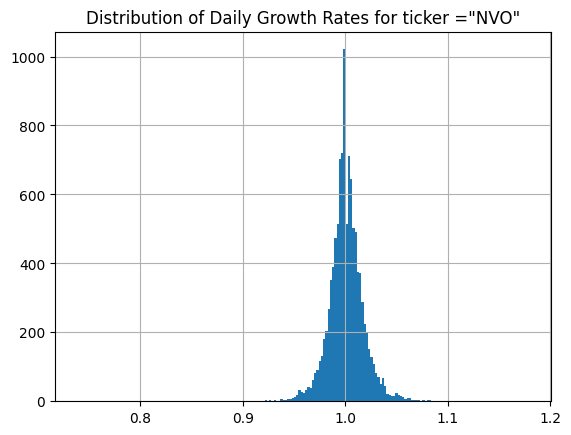

In [ ]:
# normally the growth in 1 day is +-10%, while a lot of it is around 0% (around 1.)
plt.title('Distribution of Daily Growth Rates for ticker ="NVO"')
nvo_df.growth_1d.hist(bins=200)
plt.show()

<Axes: title={'center': 'Distribution of 2-days Growth Rates for ticker = "NVO"'}>

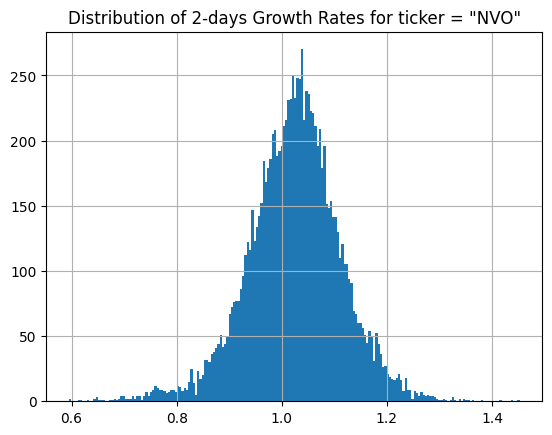

In [ ]:
# you can see that the growth is can be much wider in 30 days (+- 30%)
plt.title('Distribution of 2-days Growth Rates for ticker = "NVO"')

nvo_df.growth_30d.hist(bins=200)

In [ ]:
# for modeling: we use growth_1d, growth_2d as feature
COLUMNS = [k for k in nvo_df.keys() if k.find('growth')>=0 or k=='Adj Close']
nvo_df[COLUMNS].tail()

,Adj Close,growth_1d,growth_30d,growth_future_1d,is_positive_growth_1d_future
Date,,,,,
2024-04-19,122.709999,0.999674,0.909324,1.020781,1
2024-04-22,125.260002,1.020781,0.948101,1.026984,1
2024-04-23,128.639999,1.026984,0.987261,0.980721,0
2024-04-24,126.160004,0.980721,0.940495,0.982403,0
2024-04-25,123.940002,0.982403,0.935158,NaN,0


In [ ]:
# Calculate the distribution if future growth
nvo_df.is_positive_growth_1d_future.value_counts() / len(nvo_df)

is_positive_growth_1d_future
0    0.51301
1    0.48699
Name: count, dtype: float64

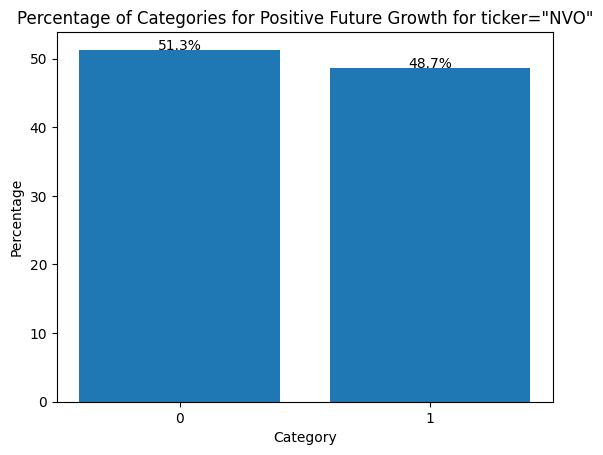

In [ ]:
# Calculate value counts
value_counts = nvo_df['is_positive_growth_1d_future'].value_counts()

# Calculate percentage of each category
percentage = (value_counts / len(nvo_df)) * 100

# Plot as a bar chart
plt.bar(percentage.index.astype(str), percentage)
plt.xlabel('Category')
plt.ylabel('Percentage')
plt.title('Percentage of Categories for Positive Future Growth for ticker="NVO"')

# Add percentage values on top of each bar
for i, value in enumerate(percentage):
    plt.text(i, value + 0, f'{value:.1f}%', ha='center')

plt.show()

## 2.2) [Code Snippet 6] Candlestick chart for OHLCV

In [ ]:
# Candlestick charts : https://plotly.com/python/candlestick-charts/
import plotly.graph_objects as go

fig = go.Figure(data=[go.Candlestick(x=nvo_df_filtered_from_2020.index,
                open=nvo_df_filtered_from_2020.Open,
                high=nvo_df_filtered_from_2020.High,
                low=nvo_df_filtered_from_2020.Low,
                close=nvo_df_filtered_from_2020.Close)
               ])

fig.update_layout(
    title="NVO's daily candlestick chart from 2020",
    title_x=0.5,  # Set title x-position to center
    xaxis_rangeslider_visible=True
    )

fig.show()

# 3) Macro Indicators

## 3.0) Previous indicators from module 1

In [ ]:
end = date.today()
print(f'Year = {end.year}; month= {end.month}; day={end.day}')

start = date(year=end.year-70, month=end.month, day=end.day)
print(f'Period for indexes: {start} to {end} ')

Year = 2024; month= 4; day=25
Period for indexes: 1954-04-25 to 2024-04-25 


In [ ]:
# reuse code for ealier covered indicators
dax_daily = yf.download(tickers = "^GDAXI",
                     period = "max",
                     interval = "1d")

[*********************100%%**********************]  1 of 1 completed


In [ ]:
for i in [1,3,7,30,90,365]:
  #DEBUG: dax_daily['Adj Close_sh_m_'+str(i)+'d'] = dax_daily['Adj Close'].shift(i)
  dax_daily['growth_dax_'+str(i)+'d'] = dax_daily['Adj Close'] / dax_daily['Adj Close'].shift(i)

In [ ]:
dax_daily.head()

,Open,High,Low,Close,Adj Close,Volume,growth_dax_1d,growth_dax_3d,growth_dax_7d,growth_dax_30d,growth_dax_90d,growth_dax_365d
Date,,,,,,,,,,,,
1987-12-30,1005.190002,1005.190002,1005.190002,1005.190002,1005.190002,0,NaN,NaN,NaN,NaN,NaN,NaN
1988-01-04,956.489990,956.489990,956.489990,956.489990,956.489990,0,0.951551,NaN,NaN,NaN,NaN,NaN
1988-01-05,996.099976,996.099976,996.099976,996.099976,996.099976,0,1.041412,NaN,NaN,NaN,NaN,NaN
1988-01-06,1006.010010,1006.010010,1006.010010,1006.010010,1006.010010,0,1.009949,1.000816,NaN,NaN,NaN,NaN
1988-01-07,1014.469971,1014.469971,1014.469971,1014.469971,1014.469971,0,1.008409,1.060617,NaN,NaN,NaN,NaN


In [ ]:
dax_daily.tail(2)

,Open,High,Low,Close,Adj Close,Volume,growth_dax_1d,growth_dax_3d,growth_dax_7d,growth_dax_30d,growth_dax_90d,growth_dax_365d
Date,,,,,,,,,,,,
2024-04-24,18140.189453,18226.320312,18060.259766,18088.699219,18088.699219,75104600,0.997301,1.019808,1.003446,1.019296,1.078888,1.267925
2024-04-25,18088.169922,18100.750000,17814.800781,17831.679688,17831.679688,0,0.985791,0.998370,1.003684,0.992573,1.064436,1.235577


In [ ]:
GROWTH_KEYS = [k for k in dax_daily.keys() if k.startswith('growth')]
dax_daily_to_merge = dax_daily[GROWTH_KEYS]
dax_daily_to_merge.tail(1)

,growth_dax_1d,growth_dax_3d,growth_dax_7d,growth_dax_30d,growth_dax_90d,growth_dax_365d
Date,,,,,,
2024-04-25,0.985791,0.99837,1.003684,0.992573,1.064436,1.235577


In [ ]:
def get_growth_df(df:pd.DataFrame, prefix:str)->pd.DataFrame:
  for i in [1,3,7,30,90,365]:
    df['growth_'+prefix+'_'+str(i)+'d'] = df['Adj Close'] / df['Adj Close'].shift(i)
    GROWTH_KEYS = [k for k in df.keys() if k.startswith('growth')]
  return df[GROWTH_KEYS]

In [ ]:
# https://finance.yahoo.com/quote/%5EGSPC/
# SNP - SNP Real Time Price. Currency in USD
snp500_daily = yf.download(tickers = "^GSPC",
                     period = "max",
                     interval = "1d")

[*********************100%%**********************]  1 of 1 completed


In [ ]:
snp500_to_merge = get_growth_df(snp500_daily,'snp500')
snp500_to_merge.tail(2)

,growth_snp500_1d,growth_snp500_3d,growth_snp500_7d,growth_snp500_30d,growth_snp500_90d,growth_snp500_365d
Date,,,,,,
2024-04-23,1.011965,1.011860,0.989683,0.990740,1.091920,1.331972
2024-04-24,1.000213,1.021018,1.001938,0.979974,1.077445,1.324839


In [ ]:
# Dow Jones Industrial Average: https://finance.yahoo.com/quote/%5EDJI?.tsrc=fin-srch
dji_daily = yf.download(tickers = "^DJI",
                     period = "max",
                     interval = "1d")

[*********************100%%**********************]  1 of 1 completed


In [ ]:
dji_daily_to_merge = get_growth_df(dji_daily,'dji')
dji_daily_to_merge.tail(2)

,growth_dji_1d,growth_dji_3d,growth_dji_7d,growth_dji_30d,growth_dji_90d,growth_dji_365d
Date,,,,,,
2024-04-24,0.998889,1.012492,1.019234,0.986039,1.036955,1.159830
2024-04-25,0.981999,0.987673,0.999196,0.967351,1.013967,1.161612


In [ ]:
# ETFs
# WisdomTree India Earnings Fund (EPI)
# NYSEArca - Nasdaq Real Time Price. Currency in USD
# WEB: https://finance.yahoo.com/quote/EPI/history?p=EPI
epi_etf_daily = yf.download(tickers = "EPI",
                     period = "max",
                     interval = "1d")
epi_etf_daily.tail(2)

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-04-24,44.660000,44.709999,44.549999,44.700001,44.700001,740600
2024-04-25,44.740002,44.834999,44.720001,44.740002,44.740002,129573


In [ ]:
epi_etf_daily_to_merge = get_growth_df(epi_etf_daily,'epi')
epi_etf_daily_to_merge.tail(2)

,growth_epi_1d,growth_epi_3d,growth_epi_7d,growth_epi_30d,growth_epi_90d,growth_epi_365d
Date,,,,,,
2024-04-24,1.001793,1.015678,1.018920,1.016140,1.114713,1.347141
2024-04-25,1.000895,1.006298,1.019134,1.053202,1.108249,1.372712


In [ ]:
# Real Potential Gross Domestic Product (GDPPOT), Billions of Chained 2012 Dollars, QUARTERLY
# https://fred.stlouisfed.org/series/GDPPOT
gdppot = pdr.DataReader("GDPPOT", "fred", start=start)
gdppot['gdppot_us_yoy'] = gdppot.GDPPOT/gdppot.GDPPOT.shift(4)-1
gdppot['gdppot_us_qoq'] = gdppot.GDPPOT/gdppot.GDPPOT.shift(1)-1
gdppot.tail(2)

,GDPPOT,gdppot_us_yoy,gdppot_us_qoq
DATE,,,
2024-01-01,22618.15,0.022251,0.005466
2024-04-01,22739.00,0.022151,0.005343


In [ ]:
gdppot_to_merge = gdppot[['gdppot_us_yoy','gdppot_us_qoq']]
gdppot_to_merge.tail(1)

,gdppot_us_yoy,gdppot_us_qoq
DATE,,
2024-04-01,0.022151,0.005343


In [ ]:
# # "Core CPI index", MONTHLY
# https://fred.stlouisfed.org/series/CPILFESL
# The "Consumer Price Index for All Urban Consumers: All Items Less Food & Energy"
# is an aggregate of prices paid by urban consumers for a typical basket of goods, excluding food and energy.
# This measurement, known as "Core CPI," is widely used by economists because food and energy have very volatile prices.
cpilfesl = pdr.DataReader("CPILFESL", "fred", start=start)
cpilfesl['cpi_core_yoy'] = cpilfesl.CPILFESL/cpilfesl.CPILFESL.shift(12)-1
cpilfesl['cpi_core_mom'] = cpilfesl.CPILFESL/cpilfesl.CPILFESL.shift(1)-1

cpilfesl.tail(2)

,CPILFESL,cpi_core_yoy,cpi_core_mom
DATE,,,
2024-02-01,315.565,0.037620,0.003584
2024-03-01,316.698,0.037973,0.003590


In [ ]:
cpilfesl_to_merge = cpilfesl[['cpi_core_yoy','cpi_core_mom']]
cpilfesl_to_merge.tail(2)

,cpi_core_yoy,cpi_core_mom
DATE,,
2024-02-01,0.037620,0.003584
2024-03-01,0.037973,0.003590


In [ ]:
# Fed rate https://fred.stlouisfed.org/series/FEDFUNDS
fedfunds = pdr.DataReader("FEDFUNDS", "fred", start=start)
fedfunds.tail(2)

,FEDFUNDS
DATE,
2024-02-01,5.33
2024-03-01,5.33


In [ ]:
# https://fred.stlouisfed.org/series/DGS1
dgs1 = pdr.DataReader("DGS1", "fred", start=start)
dgs1.tail(2)

,DGS1
DATE,
2024-04-22,5.16
2024-04-23,5.14


In [ ]:
# https://fred.stlouisfed.org/series/DGS5
dgs5 = pdr.DataReader("DGS5", "fred", start=start)
dgs5.tail(2)

,DGS5
DATE,
2024-04-22,4.66
2024-04-23,4.63


In [ ]:
# https://fred.stlouisfed.org/series/DGS10
dgs10 = pdr.DataReader("DGS10", "fred", start=start)
dgs10.tail(2)

,DGS10
DATE,
2024-04-22,4.62
2024-04-23,4.61


## 3.1) [Code snippet 3] VIX - Volatility Index

In [ ]:
# VIX - Volatility Index
# https://finance.yahoo.com/quote/%5EVIX/
vix = yf.download(tickers = "^VIX",
                     period = "max",
                     interval = "1d")

[*********************100%%**********************]  1 of 1 completed


In [ ]:
vix.tail(2)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-04-24,15.76,16.379999,15.58,15.970000,15.970000,0
2024-04-25,16.25,17.240000,16.10,17.209999,17.209999,0


In [ ]:
vix_to_merge = vix['Adj Close']
vix_to_merge.tail()

Date
2024-04-19    18.709999
2024-04-22    16.940001
2024-04-23    15.690000
2024-04-24    15.970000
2024-04-25    17.209999
Name: Adj Close, dtype: float64

<Axes: title={'center': 'VIX value over time'}, xlabel='Date'>

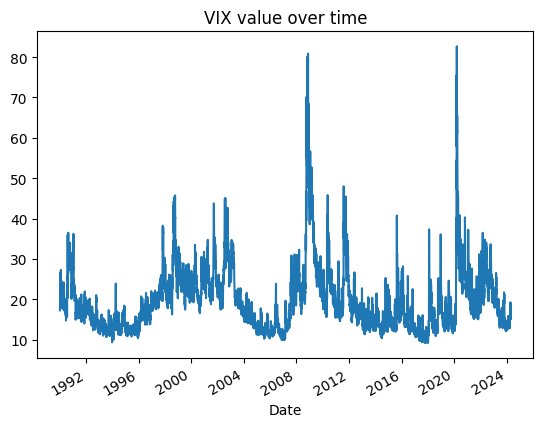

In [ ]:
# Static graphs: hard to zoom in and get the exact dates of spikes
vix['Adj Close'].plot.line(title = "VIX value over time")

In [ ]:
# Dynamic visualisation of VIX prices
fig = px.line(vix,
              x=vix.index,
              y="Adj Close",
              title='VIX over time')
fig.update_layout(title_x=0.5)  # This will center the title horizontally

fig.show()

## 3.2) Gold - other assets

In [ ]:
# GOLD
# WEB: https://finance.yahoo.com/quote/GC%3DF
gold = yf.download(tickers = "GC=F",
                     period = "max",
                     interval = "1d")

[*********************100%%**********************]  1 of 1 completed


In [ ]:
gold.tail(1)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-04-25,2327.399902,2347.399902,2316.399902,2329.399902,2329.399902,118414


In [ ]:
gold_to_merge = get_growth_df(gold,'gold')
gold_to_merge.tail(2)

,growth_gold_1d,growth_gold_3d,growth_gold_7d,growth_gold_30d,growth_gold_90d,growth_gold_365d
Date,,,,,,
2024-04-24,0.998625,0.969188,0.982543,1.075958,1.172628,1.359277
2024-04-25,1.002108,0.998799,0.974318,1.070792,1.147375,1.330857


In [ ]:
# Dynamic visualisation of GOLD prices
fig = px.line(gold,
              x=gold.index,
              y="Adj Close",
              title='GOLD over time')
fig.update_layout(title_x=0.5)  # This will center the title horizontally

fig.show()

## 3.3) WTI Crude and Brent Oil

In [ ]:
# WTI Crude Oil
# WEB: https://uk.finance.yahoo.com/quote/CL=F/
crude_oil = yf.download(tickers = "CL=F",
                     period = "max",
                     interval = "1d")

[*********************100%%**********************]  1 of 1 completed


In [ ]:
crude_oil.tail(2)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-04-24,83.400002,83.709999,82.440002,82.809998,82.809998,355814
2024-04-25,82.830002,83.330002,82.160004,82.339996,82.339996,141987


In [ ]:
crude_oil_to_merge = get_growth_df(crude_oil,'wti_oil')
crude_oil_to_merge.tail(2)

,growth_wti_oil_1d,growth_wti_oil_3d,growth_wti_oil_7d,growth_wti_oil_30d,growth_wti_oil_90d,growth_wti_oil_365d
Date,,,,,,
2024-04-24,0.993402,0.996031,0.969559,1.067690,1.192025,0.964814
2024-04-25,0.994324,0.993844,0.964620,1.032865,1.150321,0.952238


In [ ]:
# Dynamic visualisation
fig = px.line(crude_oil,
              x=crude_oil.index,
              y="Adj Close",
              title='WTI Crude Oil over time')
fig.update_layout(title_x=0.5)  # This will center the title horizontally

fig.show()

In [ ]:
# Brent Oil
# WEB: https://uk.finance.yahoo.com/quote/BZ=F/
brent_oil = yf.download(tickers = "BZ=F",
                     period = "max",
                     interval = "1d")

brent_oil.tail(2)

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-04-24,88.459999,88.800003,87.650002,88.019997,88.019997,35381
2024-04-25,88.110001,88.529999,87.419998,87.580002,87.580002,10116


In [ ]:
brent_oil_to_merge = get_growth_df(brent_oil,'brent_oil')
brent_oil_to_merge.tail(2)

,growth_brent_oil_1d,growth_brent_oil_3d,growth_brent_oil_7d,growth_brent_oil_30d,growth_brent_oil_90d,growth_brent_oil_365d
Date,,,,,,
2024-04-24,0.995476,1.008363,0.976915,1.074463,1.185295,0.950027
2024-04-25,0.995001,1.006667,0.972895,1.042247,1.143193,0.934985


In [ ]:
# Dynamic visualisation
fig = px.line(brent_oil,
              x=brent_oil.index,
              y="Adj Close",
              title='Brent Oil over time')
fig.update_layout(title_x=0.5)  # This will center the title horizontally

fig.show()


## 3.4) Bitcoin prices: BTC_USD

In [ ]:
# https://finance.yahoo.com/quote/BTC-USD/
btc_usd =  yf.download(tickers = "BTC-USD",
                     period = "max",
                     interval = "1d")

btc_usd.tail(2)

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-04-24,66408.718750,67075.367188,63589.871094,64276.898438,64276.898438,30276655120
2024-04-25,64275.988281,64674.156250,62929.230469,63381.847656,63381.847656,34861228032


In [ ]:
btc_usd_to_merge = get_growth_df(btc_usd,'btc_usd')
btc_usd_to_merge.tail(2)

,growth_btc_usd_1d,growth_btc_usd_3d,growth_btc_usd_7d,growth_btc_usd_30d,growth_btc_usd_90d,growth_btc_usd_365d
Date,,,,,,
2024-04-24,0.967920,0.989993,1.048962,0.918782,1.609586,2.270659
2024-04-25,0.986075,0.948295,0.997939,0.905612,1.515700,2.229973


In [ ]:
# Dynamic visualisation
fig = px.line(btc_usd,
              x=btc_usd.index,
              y="Adj Close",
              title='Bitcoin price daily')
fig.update_layout(title_x=0.5)  # This will center the title horizontally

fig.show()


## 3.5 [Code snippet 4] Eurostat: "The home of high-quality statistics and data on Europe"


In [ ]:
!pip install eurostat

# https://pypi.org/project/eurostat/
# https://ec.europa.eu/eurostat/web/main/data/database

In [ ]:
import eurostat

In [ ]:
# LONG WAIT TIME ~15 min, unless you filter data

# https://ec.europa.eu/eurostat/cache/metadata/en/irt_euryld_esms.htm
  # Euro yield curves (irt_euryld)
  # Reference Metadata in Euro SDMX Metadata Structure (ESMS)
  # Compiling agency: Eurostat, the statistical office of the European Uni

# the service is slow, you need to specify addtional params : https://pypi.org/project/eurostat/0.2.3/

filter_pars = {'startPeriod':'2024-04-01', 'endPeriod':'2024-05-01'}

code = 'irt_euryld_d'
eurostat_euro_yield_df = eurostat.get_data_df(code, flags=True, filter_pars=filter_pars,  verbose=True)

Download progress: 100.0%



In [ ]:
eurostat_euro_yield_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2148 entries, 0 to 2147
Data columns (total 37 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   freq              2148 non-null   object 
 1   yld_curv          2148 non-null   object 
 2   maturity          2148 non-null   object 
 3   bonds             2148 non-null   object 
 4   geo\TIME_PERIOD   2148 non-null   object 
 5   2024-04-02_value  2148 non-null   float64
 6   2024-04-02_flag   2148 non-null   object 
 7   2024-04-03_value  2148 non-null   float64
 8   2024-04-03_flag   2148 non-null   object 
 9   2024-04-04_value  2148 non-null   float64
 10  2024-04-04_flag   2148 non-null   object 
 11  2024-04-05_value  2148 non-null   float64
 12  2024-04-05_flag   2148 non-null   object 
 13  2024-04-08_value  2148 non-null   float64
 14  2024-04-08_flag   2148 non-null   object 
 15  2024-04-09_value  2148 non-null   float64
 16  2024-04-09_flag   2148 non-null   object 


In [ ]:
eurostat_euro_yield_df.head()

,freq,yld_curv,maturity,bonds,geo\TIME_PERIOD,2024-04-02_value,2024-04-02_flag,2024-04-03_value,2024-04-03_flag,2024-04-04_value,...,2024-04-17_value,2024-04-17_flag,2024-04-18_value,2024-04-18_flag,2024-04-19_value,2024-04-19_flag,2024-04-22_value,2024-04-22_flag,2024-04-23_value,2024-04-23_flag
0,D,INS_FWD,M10,CGB_EA,EA,2.93540,,2.97183,,2.92502,...,3.02343,,3.03072,,3.07889,,3.04810,,3.02264,
1,D,INS_FWD,M10,CGB_EA_AAA,EA,2.84475,,2.86360,,2.83422,...,2.90292,,2.91527,,2.95562,,2.91864,,2.91176,
2,D,INS_FWD,M11,CGB_EA,EA,2.87170,,2.90848,,2.85814,...,2.96691,,2.97286,,3.02516,,2.99413,,2.96704,
3,D,INS_FWD,M11,CGB_EA_AAA,EA,2.76744,,2.78547,,2.75286,...,2.83090,,2.84520,,2.88825,,2.84930,,2.84353,
4,D,INS_FWD,M3,CGB_EA,EA,3.61646,,3.63975,,3.62033,...,3.61198,,3.63855,,3.63585,,3.60350,,3.59855,


In [ ]:
eurostat_euro_yield_df['bonds'].value_counts()

bonds
CGB_EA        1074
CGB_EA_AAA    1074
Name: count, dtype: int64

In [ ]:
eurostat_euro_yield_df['maturity'].value_counts()


maturity
M10       6
Y26_M8    6
Y28_M4    6
Y28_M3    6
Y28_M2    6
         ..
Y18_M9    6
Y18_M8    6
Y18_M7    6
Y18_M6    6
Y9_M9     6
Name: count, Length: 358, dtype: int64

In [ ]:
eurostat_euro_yield_df['yld_curv'].value_counts()

yld_curv
INS_FWD    716
PAR        716
SPOT_RT    716
Name: count, dtype: int64

In [ ]:
eurostat_euro_yield_df

,freq,yld_curv,maturity,bonds,geo\TIME_PERIOD,2024-04-02_value,2024-04-02_flag,2024-04-03_value,2024-04-03_flag,2024-04-04_value,...,2024-04-17_value,2024-04-17_flag,2024-04-18_value,2024-04-18_flag,2024-04-19_value,2024-04-19_flag,2024-04-22_value,2024-04-22_flag,2024-04-23_value,2024-04-23_flag
0,D,INS_FWD,M10,CGB_EA,EA,2.93540,,2.97183,,2.92502,...,3.02343,,3.03072,,3.07889,,3.04810,,3.02264,
1,D,INS_FWD,M10,CGB_EA_AAA,EA,2.84475,,2.86360,,2.83422,...,2.90292,,2.91527,,2.95562,,2.91864,,2.91176,
2,D,INS_FWD,M11,CGB_EA,EA,2.87170,,2.90848,,2.85814,...,2.96691,,2.97286,,3.02516,,2.99413,,2.96704,
3,D,INS_FWD,M11,CGB_EA_AAA,EA,2.76744,,2.78547,,2.75286,...,2.83090,,2.84520,,2.88825,,2.84930,,2.84353,
4,D,INS_FWD,M3,CGB_EA,EA,3.61646,,3.63975,,3.62033,...,3.61198,,3.63855,,3.63585,,3.60350,,3.59855,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2143,D,SPOT_RT,Y9_M7,CGB_EA_AAA,EA,2.46991,,2.46791,,2.39559,...,2.52808,,2.53982,,2.56303,,2.55357,,2.54635,
2144,D,SPOT_RT,Y9_M8,CGB_EA,EA,3.05403,,3.06662,,2.97186,...,3.08455,,3.10164,,3.11870,,3.09334,,3.07345,
2145,D,SPOT_RT,Y9_M8,CGB_EA_AAA,EA,2.47321,,2.47116,,2.39873,...,2.53139,,2.54290,,2.56587,,2.55675,,2.54935,
2146,D,SPOT_RT,Y9_M9,CGB_EA,EA,3.05847,,3.07104,,2.97618,...,3.08851,,3.10564,,3.12239,,3.09720,,3.07734,


In [ ]:
# Visual graph: https://www.ecb.europa.eu/stats/financial_markets_and_interest_rates/euro_area_yield_curves/html/index.en.html
FILTER = (eurostat_euro_yield_df.yld_curv=='SPOT_RT')& (eurostat_euro_yield_df.bonds=='CGB_EA_AAA')
filtered_eurostat_euro_yield_df = eurostat_euro_yield_df[FILTER]

In [ ]:
filtered_eurostat_euro_yield_df.sort_values(by='maturity')[['maturity','2024-04-18_value']].head(20)

,maturity,2024-04-18_value
1433,M10,3.36335
1435,M11,3.31940
1437,M3,3.72264
1439,M4,3.66536
1441,M5,3.61017
1443,M6,3.55700
1445,M7,3.50580
1447,M8,3.45649
1449,M9,3.40903
1451,Y1,3.27711


In [ ]:
import re

def extract_numbers(input_string):
    y_match = re.search(r'Y(\d+)', input_string)
    m_match = re.search(r'M(\d+)', input_string)

    y_number = int(y_match.group(1)) if y_match else 0
    m_number = int(m_match.group(1)) if m_match else 0


    return y_number*12 + m_number

# Examples
examples = ["Y10_M2", "M3", "Y1"]
for example in examples:
    res = extract_numbers(example)
    print(f"{example} ==> {res}")

Y10_M2 ==> 122
M3 ==> 3
Y1 ==> 12


In [ ]:
# define new field: "maturity in months"
filtered_eurostat_euro_yield_df['maturity_in_months'] = filtered_eurostat_euro_yield_df.maturity.apply(lambda x:extract_numbers(x))

<ipython-input-102-ffa8baf09650>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
filtered_eurostat_euro_yield_df.sort_values(by='maturity_in_months')[['maturity','maturity_in_months','2024-04-18_value']].head(20)

,maturity,maturity_in_months,2024-04-18_value
1437,M3,3,3.72264
1439,M4,4,3.66536
1441,M5,5,3.61017
1443,M6,6,3.55700
1445,M7,7,3.50580
1447,M8,8,3.45649
1449,M9,9,3.40903
1433,M10,10,3.36335
1435,M11,11,3.31940
1451,Y1,12,3.27711


In [ ]:
filtered_eurostat_euro_yield_df.loc[:,'maturity_in_years'] = filtered_eurostat_euro_yield_df.maturity_in_months/12.0

<ipython-input-105-c3c6c300f9f8>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<Axes: title={'center': 'AAA rated bonds spot yield curve'}, xlabel='maturity_in_years'>

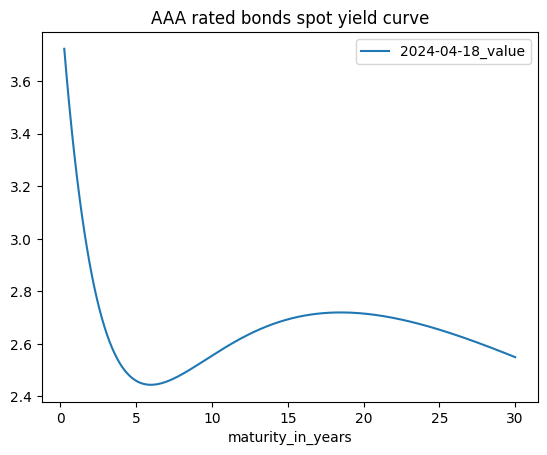

In [ ]:
# exactly the same as on the Web:  https://www.ecb.europa.eu/stats/financial_markets_and_interest_rates/euro_area_yield_curves/html/index.en.html
filtered_eurostat_euro_yield_df \
  .sort_values(by='maturity_in_months')[['maturity_in_years','2024-04-18_value']] \
  .plot.line(x='maturity_in_years',
            y='2024-04-18_value',
            title='AAA rated bonds spot yield curve')

# 4) [Code Snippet 5] Fundamental indicators

* Read about "Ratio Analysis" to learn about more ratios: https://www.investopedia.com/terms/r/ratioanalysis.asp
* https://algotrading101.com/learn/yahoo-finance-api-guide/

In [ ]:
# let's select some set of stocks: e.g. top US companies on 'Employees':
# https://companiesmarketcap.com/usa/largest-american-companies-by-number-of-employees/

US_TOP_EMPLOYEES_STOCKS = ['WMT','AMZN','UPS','HD','CNXC','TGT','KR','UNH','BRK-B','SBUX']

# WMT
ticker = US_TOP_EMPLOYEES_STOCKS[0]

# WMT ticker
one_company = yf.Ticker(ticker)

In [ ]:
# Fundamental info appears close earning dates, you need to download it and use quickly (before/after trading day),
#  unless you're a fundamental long-term investor looking for a several months-quarters-years strategy (period between buy and sell)
# This dfthis is the easiest thing to join with the main dataset and get "some" technical indicators present
eps_earnings = one_company.earnings_dates
eps_earnings['Ticker'] = ticker
eps_earnings

,EPS Estimate,Reported EPS,Surprise(%),Ticker
Earnings Date,,,,
2025-02-20 08:00:00-05:00,NaN,NaN,NaN,WMT
2024-11-19 08:00:00-05:00,NaN,NaN,NaN,WMT
2024-08-15 08:00:00-04:00,NaN,NaN,NaN,WMT
2024-05-30 11:00:00-04:00,0.52,NaN,NaN,WMT
2024-05-16 08:00:00-04:00,0.52,NaN,NaN,WMT
2024-04-10 06:00:00-04:00,0.55,0.6,0.0909,WMT
2024-04-03 06:00:00-04:00,0.55,0.6,0.0909,WMT
2024-03-28 06:00:00-04:00,0.55,0.6,0.0909,WMT
2024-03-26 06:00:00-04:00,0.55,0.6,0.0909,WMT


In [ ]:
one_company.calendar

{'Dividend Date': datetime.date(2025, 1, 6),
 'Ex-Dividend Date': datetime.date(2024, 5, 9),
 'Earnings Date': [datetime.date(2024, 5, 16)],
 'Earnings High': 0.55,
 'Earnings Low': 0.51,
 'Earnings Average': 0.52,
 'Revenue High': 160755000000,
 'Revenue Low': 157591000000,
 'Revenue Average': 159344000000}

In [ ]:
one_company.financials

,2024-01-31,2023-01-31,2022-01-31,2021-01-31
Tax Effect Of Unusual Items,0.0,0.0,-612140000.0,0.0
Tax Rate For Calcs,0.255,0.336,0.254,0.333
Normalized EBITDA,36384000000.0,30089000000.0,33758000000.0,34031000000.0
Total Unusual Items,0.0,0.0,-2410000000.0,0.0
Total Unusual Items Excluding Goodwill,0.0,0.0,-2410000000.0,0.0
Net Income From Continuing Operation Net Minority Interest,15511000000.0,11680000000.0,13673000000.0,13510000000.0
Reconciled Depreciation,11853000000.0,10945000000.0,10658000000.0,11152000000.0
Reconciled Cost Of Revenue,490142000000.0,463721000000.0,429000000000.0,420315000000.0
EBITDA,36384000000.0,30089000000.0,31348000000.0,34031000000.0
EBIT,24531000000.0,19144000000.0,20690000000.0,22879000000.0


In [ ]:
EPS = one_company.financials.loc['Basic EPS']
EPS

2024-01-31    1.92
2023-01-31    1.43
2022-01-31    1.63
2021-01-31    1.59
Name: Basic EPS, dtype: object

In [ ]:
# or should we use NORMALIZED_EBITDA?
EBITDA = one_company.financials.loc['EBITDA']
EBITDA_margin = one_company.financials.loc['EBITDA'] /  one_company.financials.loc['Total Revenue']

In [ ]:
EBITDA_margin

2024-01-31    0.056137
2023-01-31    0.049222
2022-01-31    0.054732
2021-01-31    0.060862
dtype: object

In [ ]:
NET_INCOME = one_company.financials.loc['Net Income']
NET_INCOME_margin = one_company.financials.loc['Net Income'] /  one_company.financials.loc['Total Revenue']

In [ ]:
NET_INCOME

2024-01-31    15511000000.0
2023-01-31    11680000000.0
2022-01-31    13673000000.0
2021-01-31    13510000000.0
Name: Net Income, dtype: object

In [ ]:
# Compare with Public information - you can fully replicate the numbers (yearly and/or quarterly):
# https://www.wsj.com/market-data/quotes/WMT/financials/annual/income-statement
NET_INCOME_margin

2024-01-31    0.023932
2023-01-31    0.019107
2022-01-31    0.023872
2021-01-31    0.024162
dtype: object

In [ ]:
# Combine the series into a DataFrame
df_fin_ratios = pd.DataFrame({
    'NET_INCOME_margin': 100.0 * NET_INCOME_margin, #for visualisation -- Margin in %
    'EBITDA_margin': 100.0 *EBITDA_margin, #for visualisation -- Margin in %
    'EPS': EPS
})

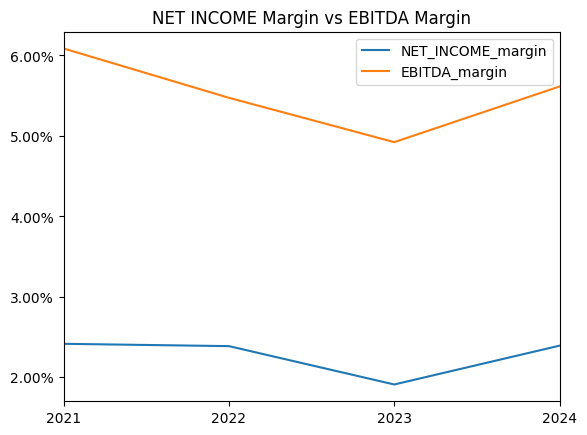

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Assuming df_fin_ratios is your DataFrame containing the financial ratios
# Make sure you have already created this DataFrame

# Plotting the specified columns
ax = df_fin_ratios[['NET_INCOME_margin','EBITDA_margin']].plot.line()

# Setting the y-axis formatter to display values as percentages
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

# Adding title
plt.title('NET INCOME Margin vs EBITDA Margin')

# Displaying the plot
plt.show()

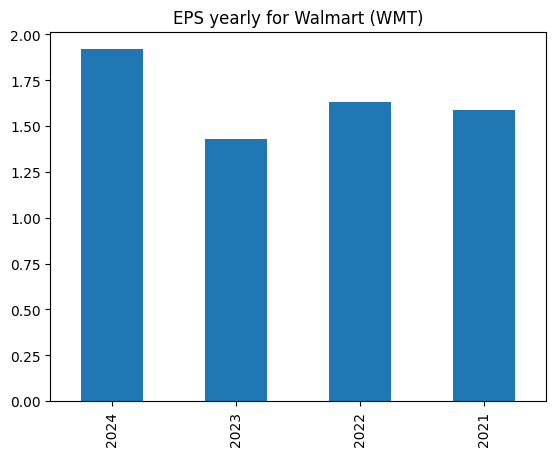

In [ ]:
EPS_year = df_fin_ratios['EPS'].index.year

df_fin_ratios['EPS'].plot.bar(title = 'EPS yearly for Walmart (WMT)')

plt.xticks(range(len(EPS_year)), EPS_year)
# Displaying the plot
plt.show()

# 5) [Code snippet 7] Daily OHCLV data for a set of stocks

In [ ]:
# https://companiesmarketcap.com/usa/largest-companies-in-the-usa-by-market-cap/
US_STOCKS = ['MSFT', 'AAPL', 'GOOG', 'NVDA', 'AMZN', 'META', 'BRK-B', 'LLY', 'AVGO','V', 'JPM']

# You're required to add EU_STOCKS and INDIA_STOCS
# https://companiesmarketcap.com/european-union/largest-companies-in-the-eu-by-market-cap/
EU_STOCKS = ['NVO','MC.PA', 'ASML', 'RMS.PA', 'OR.PA', 'SAP', 'ACN', 'TTE', 'SIE.DE','IDEXY','CDI.PA']

# https://companiesmarketcap.com/india/largest-companies-in-india-by-market-cap/
INDIA_STOCKS = ['RELIANCE.NS','TCS.NS','HDB','BHARTIARTL.NS','IBN','SBIN.NS','LICI.NS','INFY','ITC.NS','HINDUNILVR.NS','LT.NS']

In [ ]:
ALL_TICKERS = US_STOCKS  + EU_STOCKS + INDIA_STOCKS
ALL_TICKERS

['MSFT',
 'AAPL',
 'GOOG',
 'NVDA',
 'AMZN',
 'META',
 'BRK-B',
 'LLY',
 'AVGO',
 'V',
 'JPM',
 'NVO',
 'MC.PA',
 'ASML',
 'RMS.PA',
 'OR.PA',
 'SAP',
 'ACN',
 'TTE',
 'SIE.DE',
 'IDEXY',
 'CDI.PA',
 'RELIANCE.NS',
 'TCS.NS',
 'HDB',
 'BHARTIARTL.NS',
 'IBN',
 'SBIN.NS',
 'LICI.NS',
 'INFY',
 'ITC.NS',
 'HINDUNILVR.NS',
 'LT.NS']

In [ ]:
import time

stocks_df = pd.DataFrame({'A' : []})

for i,ticker in enumerate(ALL_TICKERS):
  print(i,ticker)

  # Work with stock prices
  historyPrices = yf.download(tickers = ticker,
                     period = "max",
                     interval = "1d")

  # generate features for historical prices, and what we want to predict
  historyPrices['Ticker'] = ticker
  historyPrices['Year']= historyPrices.index.year
  historyPrices['Month'] = historyPrices.index.month
  historyPrices['Weekday'] = historyPrices.index.weekday
  historyPrices['Date'] = historyPrices.index.date

  # historical returns
  for i in [1,3,7,30,90,365]:
    historyPrices['growth_'+str(i)+'d'] = historyPrices['Adj Close'] / historyPrices['Adj Close'].shift(i)
  historyPrices['growth_future_5d'] = historyPrices['Adj Close'].shift(-5) / historyPrices['Adj Close']

  # Technical indicators
  # SimpleMovingAverage 10 days and 20 days
  historyPrices['SMA10']= historyPrices['Close'].rolling(10).mean()
  historyPrices['SMA20']= historyPrices['Close'].rolling(20).mean()
  historyPrices['growing_moving_average'] = np.where(historyPrices['SMA10'] > historyPrices['SMA20'], 1, 0)
  historyPrices['high_minus_low_relative'] = (historyPrices.High - historyPrices.Low) / historyPrices['Adj Close']

  # 30d rolling volatility : https://ycharts.com/glossary/terms/rolling_vol_30
  historyPrices['volatility'] =   historyPrices['Adj Close'].rolling(30).std() * np.sqrt(252)

  # what we want to predict
  historyPrices['is_positive_growth_5d_future'] = np.where(historyPrices['growth_future_5d'] > 1, 1, 0)

  # sleep 1 sec between downloads - not to overload the API server
  time.sleep(1)


  if stocks_df.empty:
    stocks_df = historyPrices
  else:
    stocks_df = pd.concat([stocks_df, historyPrices], ignore_index=True)

0 MSFT


[*********************100%%**********************]  1 of 1 completed


1 AAPL


[*********************100%%**********************]  1 of 1 completed


2 GOOG


[*********************100%%**********************]  1 of 1 completed


3 NVDA


[*********************100%%**********************]  1 of 1 completed


4 AMZN


[*********************100%%**********************]  1 of 1 completed


5 META


[*********************100%%**********************]  1 of 1 completed


6 BRK-B


[*********************100%%**********************]  1 of 1 completed


7 LLY


[*********************100%%**********************]  1 of 1 completed


8 AVGO


[*********************100%%**********************]  1 of 1 completed


9 V


[*********************100%%**********************]  1 of 1 completed


10 JPM


[*********************100%%**********************]  1 of 1 completed


11 NVO


[*********************100%%**********************]  1 of 1 completed


12 MC.PA


[*********************100%%**********************]  1 of 1 completed


13 ASML


[*********************100%%**********************]  1 of 1 completed


14 RMS.PA


[*********************100%%**********************]  1 of 1 completed


15 OR.PA


[*********************100%%**********************]  1 of 1 completed


16 SAP


[*********************100%%**********************]  1 of 1 completed


17 ACN


[*********************100%%**********************]  1 of 1 completed


18 TTE


[*********************100%%**********************]  1 of 1 completed


19 SIE.DE


[*********************100%%**********************]  1 of 1 completed


20 IDEXY


[*********************100%%**********************]  1 of 1 completed


21 CDI.PA


[*********************100%%**********************]  1 of 1 completed


22 RELIANCE.NS


[*********************100%%**********************]  1 of 1 completed


23 TCS.NS


[*********************100%%**********************]  1 of 1 completed


24 HDB


[*********************100%%**********************]  1 of 1 completed


25 BHARTIARTL.NS


[*********************100%%**********************]  1 of 1 completed


26 IBN


[*********************100%%**********************]  1 of 1 completed


27 SBIN.NS


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

28 LICI.NS


29 INFY


[*********************100%%**********************]  1 of 1 completed


30 ITC.NS


[*********************100%%**********************]  1 of 1 completed


31 HINDUNILVR.NS


[*********************100%%**********************]  1 of 1 completed


32 LT.NS


[*********************100%%**********************]  1 of 1 completed


In [ ]:
def get_ticker_type(ticker:str, us_stocks_list, eu_stocks_list, india_stocks_list):
  if ticker in us_stocks_list:
    return 'US'
  elif ticker in eu_stocks_list:
    return 'EU'
  elif ticker in india_stocks_list:
    return 'INDIA'
  else:
    return 'ERROR'


In [ ]:
stocks_df['ticker_type'] = stocks_df.Ticker.apply(lambda x:get_ticker_type(x, US_STOCKS, EU_STOCKS, INDIA_STOCKS))

In [ ]:
# count of observations between US-EU-INDIA stocks
stocks_df.ticker_type.value_counts()

ticker_type
US       80639
EU       76986
INDIA    63265
Name: count, dtype: int64

In [ ]:
# unique tickers
stocks_df.Ticker.nunique()

33

In [ ]:
# count of observations by stock
stocks_df.Ticker.value_counts()

Ticker
LLY              13087
JPM              11121
AAPL             10933
NVO              10838
MSFT              9607
CDI.PA            8321
TTE               8185
ASML              7330
SAP               7201
HINDUNILVR.NS     7115
SBIN.NS           7113
RELIANCE.NS       7112
ITC.NS            7112
SIE.DE            7039
BRK-B             7038
AMZN              6780
NVDA              6356
INFY              6323
MC.PA             6251
RMS.PA            6251
OR.PA             6251
IBN               6058
ACN               5728
HDB               5727
LT.NS             5420
BHARTIARTL.NS     5417
TCS.NS            5388
GOOG              4955
V                 4054
AVGO              3705
IDEXY             3591
META              3003
LICI.NS            480
Name: count, dtype: int64

In [ ]:
stocks_df.groupby(['Ticker','ticker_type']).Date.agg(['min','max'])

,,min,max
Ticker,ticker_type,,
AAPL,US,1980-12-12,2024-04-25
ACN,EU,2001-07-19,2024-04-25
AMZN,US,1997-05-15,2024-04-24
ASML,EU,1995-03-15,2024-04-25
AVGO,US,2009-08-06,2024-04-25
BHARTIARTL.NS,INDIA,2002-07-01,2024-04-25
BRK-B,US,1996-05-09,2024-04-25
CDI.PA,EU,1992-01-27,2024-04-25
GOOG,US,2004-08-19,2024-04-25


In [ ]:
#  average growth 365days
stocks_df[stocks_df.Year>=2020].groupby(by=['Year','ticker_type']).growth_365d.mean()

Year  ticker_type
2020  EU             1.245388
      INDIA          1.101896
      US             1.484070
2021  EU             1.582170
      INDIA          1.546424
      US             1.797571
2022  EU             1.191169
      INDIA          1.379889
      US             1.182379
2023  EU             1.246533
      INDIA          1.201110
      US             1.203253
2024  EU             1.650721
      INDIA          1.305762
      US             2.153187
Name: growth_365d, dtype: float64

In [ ]:
stocks_df['Date'] = pd.to_datetime(stocks_df['Date'])

In [ ]:
# filtering only on stats after 2000
stocks_df[stocks_df.Date>='2000-01-01'].info()

<class 'pandas.core.frame.DataFrame'>
Index: 182423 entries, 3490 to 220889
Data columns (total 25 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   Open                          182423 non-null  float64       
 1   High                          182423 non-null  float64       
 2   Low                           182423 non-null  float64       
 3   Close                         182423 non-null  float64       
 4   Adj Close                     182423 non-null  float64       
 5   Volume                        182423 non-null  int64         
 6   Ticker                        182423 non-null  object        
 7   Year                          182423 non-null  int32         
 8   Month                         182423 non-null  int32         
 9   Weekday                       182423 non-null  int32         
 10  Date                          182423 non-null  datetime64[ns]
 11  growth_1d      

In [ ]:
stocks_df[stocks_df.Date=='2024-04-01'].tail()

,Open,High,Low,Close,Adj Close,Volume,Ticker,Year,Month,Weekday,...,growth_90d,growth_365d,growth_future_5d,SMA10,SMA20,growing_moving_average,high_minus_low_relative,volatility,is_positive_growth_5d_future,ticker_type
194903,925.000000,984.450012,924.000000,970.599976,970.599976,4863536,LICI.NS,2024,4,0,...,1.599113,1.556710,1.026891,906.085004,953.950003,0,0.062281,1034.237352,1,INDIA
201224,17.889999,17.920000,17.500000,17.580000,17.580000,14601600,INFY,2024,4,0,...,1.003998,1.024508,1.015927,18.156000,18.777500,0,0.023891,13.940634,1,INDIA
208338,429.100006,431.350006,425.750000,426.700012,426.700012,9382308,ITC.NS,2024,4,0,...,0.987044,1.314436,1.005625,422.235004,416.537502,1,0.013124,130.246651,1,INDIA
215453,2270.000000,2295.000000,2262.000000,2285.899902,2285.899902,1427873,HINDUNILVR.NS,2024,4,0,...,0.917590,0.894051,0.992585,2266.539990,2327.240015,0,0.014436,1049.970071,0,INDIA
220873,3780.850098,3851.850098,3780.850098,3838.000000,3838.000000,1905190,LT.NS,2024,4,0,...,1.257886,2.010850,0.992144,3626.594971,3618.109985,1,0.018499,2188.619806,0,INDIA


#6) [Code Snippet 8] Technical Indicators with TA-lib
* PythonInvest article on Tech. Indicators
* Code for generating 100+ tech. indicators/patterns : https://github.com/realmistic/PythonInvest-basic-fin-analysis/blob/master/colab_notebooks/Part14_Exploring_Tech_Indicators_For_Stocks_and_Crypto.ipynb

Indicator groups: https://github.com/TA-Lib/ta-lib-python/blob/master/README.md

* Overlap Studies (17)
* Momentum Indicators (30+)
* Volume Indicators (3)
* Cycle Indicators (5)
* Price Transform (4)
* Volatility Indicators (3)
* Pattern Recognition (60)

In [ ]:
# https://stackoverflow.com/questions/49648391/how-to-install-ta-lib-in-google-colab
# Update (apr 2023): Colab is now Python 3.10
# there are some other (older) ways to install talib

url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py310hde88566_4.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.10/dist-packages/ lib/python3.10/site-packages/talib --strip-components=3
import talib

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4099    0  4099    0     0  10503      0 --:--:-- --:--:-- --:--:-- 10483
100  517k  100  517k    0     0   707k      0 --:--:-- --:--:-- --:--:--  707k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4067    0  4067    0     0   3782      0 --:--:--  0:00:01 --:--:--  3783
100  392k  100  392k    0     0   282k      0  0:00:01  0:00:01 --:--:-- 12.1M


## 6.1) Momentum indicators
https://github.com/TA-Lib/ta-lib-python/blob/master/docs/func_groups/momentum_indicators.md

In [ ]:
def talib_get_momentum_indicators_for_one_ticker(df: pd.DataFrame) -> pd.DataFrame:
  # ADX - Average Directional Movement Index
  talib_momentum_adx = talib.ADX(df.High.values, df.Low.values, df.Close.values, timeperiod=14)
  # ADXR - Average Directional Movement Index Rating
  talib_momentum_adxr = talib.ADXR(df.High.values, df.Low.values, df.Close.values, timeperiod=14 )
  # APO - Absolute Price Oscillator
  talib_momentum_apo = talib.APO(df.Close.values, fastperiod=12, slowperiod=26, matype=0 )
  # AROON - Aroon
  talib_momentum_aroon = talib.AROON(df.High.values, df.Low.values, timeperiod=14 )
  # talib_momentum_aroon[0].size
  # talib_momentum_aroon[1].size
  # AROONOSC - Aroon Oscillator
  talib_momentum_aroonosc = talib.AROONOSC(df.High.values, df.Low.values, timeperiod=14)
  # BOP - Balance of Power
  # https://school.stockcharts.com/doku.php?id=technical_indicators:balance_of_power
     #calculate open prices as shifted closed prices from the prev day
     # open = df.Last.shift(1)
  talib_momentum_bop = talib.BOP(df.Open.values, df.High.values, df.Low.values, df.Close.values)
  # CCI - Commodity Channel Index
  talib_momentum_cci = talib.CCI(df.High.values, df.Low.values, df.Close.values, timeperiod=14)
  # CMO - Chande Momentum Oscillator
  talib_momentum_cmo = talib.CMO(df.Close.values, timeperiod=14)
  # DX - Directional Movement Index
  talib_momentum_dx = talib.DX(df.High.values, df.Low.values, df.Close.values, timeperiod=14)
  # MACD - Moving Average Convergence/Divergence
  talib_momentum_macd, talib_momentum_macdsignal, talib_momentum_macdhist = talib.MACD(df.Close.values, fastperiod=12, \
                                                                                       slowperiod=26, signalperiod=9)
  # MACDEXT - MACD with controllable MA type
  talib_momentum_macd_ext, talib_momentum_macdsignal_ext, talib_momentum_macdhist_ext = talib.MACDEXT(df.Close.values, \
                                                                                                    fastperiod=12, \
                                                                                                    fastmatype=0, \
                                                                                                    slowperiod=26, \
                                                                                                    slowmatype=0, \
                                                                                                    signalperiod=9, \
                                                                                                  signalmatype=0)
  # MACDFIX - Moving Average Convergence/Divergence Fix 12/26
  talib_momentum_macd_fix, talib_momentum_macdsignal_fix, talib_momentum_macdhist_fix = talib.MACDFIX(df.Close.values, \
                                                                                                      signalperiod=9)
  # MFI - Money Flow Index
  talib_momentum_mfi = talib.MFI(df.High.values, df.Low.values, df.Close.values, df.Volume.values, timeperiod=14)
  # MINUS_DI - Minus Directional Indicator
  talib_momentum_minus_di = talib.MINUS_DM(df.High.values, df.Low.values, timeperiod=14)
  # MOM - Momentum
  talib_momentum_mom = talib.MOM(df.Close.values, timeperiod=10)
  # PLUS_DI - Plus Directional Indicator
  talib_momentum_plus_di = talib.PLUS_DI(df.High.values, df.Low.values, df.Close.values, timeperiod=14)
  # PLUS_DM - Plus Directional Movement
  talib_momentum_plus_dm = talib.PLUS_DM(df.High.values, df.Low.values, timeperiod=14)
  # PPO - Percentage Price Oscillator
  talib_momentum_ppo = talib.PPO(df.Close.values, fastperiod=12, slowperiod=26, matype=0)
  # ROC - Rate of change : ((price/prevPrice)-1)*100
  talib_momentum_roc = talib.ROC(df.Close.values, timeperiod=10)
  # ROCP - Rate of change Percentage: (price-prevPrice)/prevPrice
  talib_momentum_rocp = talib.ROCP(df.Close.values, timeperiod=10)
  # ROCR - Rate of change ratio: (price/prevPrice)
  talib_momentum_rocr = talib.ROCR(df.Close.values, timeperiod=10)
  # ROCR100 - Rate of change ratio 100 scale: (price/prevPrice)*100
  talib_momentum_rocr100 = talib.ROCR100(df.Close.values, timeperiod=10)
  # RSI - Relative Strength Index
  talib_momentum_rsi = talib.RSI(df.Close.values, timeperiod=14)
  # STOCH - Stochastic
  talib_momentum_slowk, talib_momentum_slowd = talib.STOCH(df.High.values, df.Low.values, df.Close.values, \
                                                           fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
  # STOCHF - Stochastic Fast
  talib_momentum_fastk, talib_momentum_fastd = talib.STOCHF(df.High.values, df.Low.values, df.Close.values, \
                                                            fastk_period=5, fastd_period=3, fastd_matype=0)
  # STOCHRSI - Stochastic Relative Strength Index
  talib_momentum_fastk_rsi, talib_momentum_fastd_rsi = talib.STOCHRSI(df.Close.values, timeperiod=14, \
                                                                      fastk_period=5, fastd_period=3, fastd_matype=0)
  # TRIX - 1-day Rate-Of-Change (ROC) of a Triple Smooth EMA
  talib_momentum_trix = talib.TRIX(df.Close.values, timeperiod=30)
  # ULTOSC - Ultimate Oscillator
  talib_momentum_ultosc = talib.ULTOSC(df.High.values, df.Low.values, df.Close.values, timeperiod1=7, timeperiod2=14, timeperiod3=28)
  # WILLR - Williams' %R
  talib_momentum_willr = talib.WILLR(df.High.values, df.Low.values, df.Close.values, timeperiod=14)

  momentum_df =   pd.DataFrame(
    {
      # assume here multi-index <dateTime, ticker>
      # 'datetime': df.index.get_level_values(0),
      # 'ticker': df.index.get_level_values(1) ,

      # old way with separate columns
      'Date': df.Date.values,
      'Ticker': df.Ticker,

      'adx': talib_momentum_adx,
      'adxr': talib_momentum_adxr,
      'apo': talib_momentum_apo,
      'aroon_1': talib_momentum_aroon[0] ,
      'aroon_2': talib_momentum_aroon[1],
      'aroonosc': talib_momentum_aroonosc,
      'bop': talib_momentum_bop,
      'cci': talib_momentum_cci,
      'cmo': talib_momentum_cmo,
      'dx': talib_momentum_dx,
      'macd': talib_momentum_macd,
      'macdsignal': talib_momentum_macdsignal,
      'macdhist': talib_momentum_macdhist,
      'macd_ext': talib_momentum_macd_ext,
      'macdsignal_ext': talib_momentum_macdsignal_ext,
      'macdhist_ext': talib_momentum_macdhist_ext,
      'macd_fix': talib_momentum_macd_fix,
      'macdsignal_fix': talib_momentum_macdsignal_fix,
      'macdhist_fix': talib_momentum_macdhist_fix,
      'mfi': talib_momentum_mfi,
      'minus_di': talib_momentum_minus_di,
      'mom': talib_momentum_mom,
      'plus_di': talib_momentum_plus_di,
      'dm': talib_momentum_plus_dm,
      'ppo': talib_momentum_ppo,
      'roc': talib_momentum_roc,
      'rocp': talib_momentum_rocp,
      'rocr': talib_momentum_rocr,
      'rocr100': talib_momentum_rocr100,
      'rsi': talib_momentum_rsi,
      'slowk': talib_momentum_slowk,
      'slowd': talib_momentum_slowd,
      'fastk': talib_momentum_fastk,
      'fastd': talib_momentum_fastd,
      'fastk_rsi': talib_momentum_fastk_rsi,
      'fastd_rsi': talib_momentum_fastd_rsi,
      'trix': talib_momentum_trix,
      'ultosc': talib_momentum_ultosc,
      'willr': talib_momentum_willr,
     }
  )
  return momentum_df

## 6.2 Volume, Volatility, Cycle, Price indicators
https://github.com/TA-Lib/ta-lib-python/blob/master/docs/func_groups/volume_indicators.md

In [ ]:
def talib_get_volume_volatility_cycle_price_indicators(df: pd.DataFrame) -> pd.DataFrame:
        # TA-Lib Volume indicators
        # https://github.com/TA-Lib/ta-lib-python/blob/master/docs/func_groups/volume_indicators.md
        # AD - Chaikin A/D Line
        talib_ad = talib.AD(
            df.High.values, df.Low.values, df.Close.values, df.Volume.values)
        # ADOSC - Chaikin A/D Oscillator
        talib_adosc = talib.ADOSC(
            df.High.values, df.Low.values, df.Close.values, df.Volume.values, fastperiod=3, slowperiod=10)
        # OBV - On Balance Volume
        talib_obv = talib.OBV(
            df.Close.values, df.Volume.values)

        # TA-Lib Volatility indicators
        # https://github.com/TA-Lib/ta-lib-python/blob/master/docs/func_groups/volatility_indicators.md
        # ATR - Average True Range
        talib_atr = talib.ATR(
            df.High.values, df.Low.values, df.Close.values, timeperiod=14)
        # NATR - Normalized Average True Range
        talib_natr = talib.NATR(
            df.High.values, df.Low.values, df.Close.values, timeperiod=14)
        # OBV - On Balance Volume
        talib_obv = talib.OBV(
            df.Close.values, df.Volume.values)

        # TA-Lib Cycle Indicators
        # https://github.com/TA-Lib/ta-lib-python/blob/master/docs/func_groups/cycle_indicators.md
        # HT_DCPERIOD - Hilbert Transform - Dominant Cycle Period
        talib_ht_dcperiod = talib.HT_DCPERIOD(df.Close.values)
        # HT_DCPHASE - Hilbert Transform - Dominant Cycle Phase
        talib_ht_dcphase = talib.HT_DCPHASE(df.Close.values)
        # HT_PHASOR - Hilbert Transform - Phasor Components
        talib_ht_phasor_inphase, talib_ht_phasor_quadrature = talib.HT_PHASOR(
            df.Close.values)
        # HT_SINE - Hilbert Transform - SineWave
        talib_ht_sine_sine, talib_ht_sine_leadsine = talib.HT_SINE(
            df.Close.values)
        # HT_TRENDMODE - Hilbert Transform - Trend vs Cycle Mode
        talib_ht_trendmode = talib.HT_TRENDMODE(df.Close.values)

        # TA-Lib Price Transform Functions
        # https://github.com/TA-Lib/ta-lib-python/blob/master/docs/func_groups/price_transform.md
        # AVGPRICE - Average Price
        talib_avgprice = talib.AVGPRICE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # MEDPRICE - Median Price
        talib_medprice = talib.MEDPRICE(df.High.values, df.Low.values)
        # TYPPRICE - Typical Price
        talib_typprice = talib.TYPPRICE(
            df.High.values, df.Low.values, df.Close.values)
        # WCLPRICE - Weighted Close Price
        talib_wclprice = talib.WCLPRICE(
            df.High.values, df.Low.values, df.Close.values)

        volume_volatility_cycle_price_df = pd.DataFrame(
            {'Date': df.Date.values,
             'Ticker': df.Ticker,
             # TA-Lib Volume indicators
             'ad': talib_ad,
             'adosc': talib_adosc,
             'obv': talib_obv,
             # TA-Lib Volatility indicators
             'atr': talib_atr,
             'natr': talib_natr,
             'obv': talib_obv,
             # TA-Lib Cycle Indicators
             'ht_dcperiod': talib_ht_dcperiod,
             'ht_dcphase': talib_ht_dcphase,
             'ht_phasor_inphase': talib_ht_phasor_inphase,
             'ht_phasor_quadrature': talib_ht_phasor_quadrature,
             'ht_sine_sine': talib_ht_sine_sine,
             'ht_sine_leadsine': talib_ht_sine_leadsine,
             'ht_trendmod': talib_ht_trendmode,
             # TA-Lib Price Transform Functions
             'avgprice': talib_avgprice,
             'medprice': talib_medprice,
             'typprice': talib_typprice,
             'wclprice': talib_wclprice,
             }
        )

        # Need a proper date type
        volume_volatility_cycle_price_df['Date'] = pd.to_datetime(
            volume_volatility_cycle_price_df['Date'])

        return volume_volatility_cycle_price_df

## 6.3) Pattern indicators
https://github.com/TA-Lib/ta-lib-python/blob/master/docs/func_groups/pattern_recognition.md

In [ ]:
def talib_get_pattern_recognition_indicators(df: pd.DataFrame) -> pd.DataFrame:
# TA-Lib Pattern Recognition indicators
        # https://github.com/TA-Lib/ta-lib-python/blob/master/docs/func_groups/pattern_recognition.md
        # Nice article about candles (pattern recognition) https://medium.com/analytics-vidhya/recognizing-over-50-candlestick-patterns-with-python-4f02a1822cb5

        # CDL2CROWS - Two Crows
        talib_cdl2crows = talib.CDL2CROWS(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDL3BLACKCROWS - Three Black Crows
        talib_cdl3blackrows = talib.CDL3BLACKCROWS(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDL3INSIDE - Three Inside Up/Down
        talib_cdl3inside = talib.CDL3INSIDE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDL3LINESTRIKE - Three-Line Strike
        talib_cdl3linestrike = talib.CDL3LINESTRIKE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDL3OUTSIDE - Three Outside Up/Down
        talib_cdl3outside = talib.CDL3OUTSIDE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDL3STARSINSOUTH - Three Stars In The South
        talib_cdl3starsinsouth = talib.CDL3STARSINSOUTH(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDL3WHITESOLDIERS - Three Advancing White Soldiers
        talib_cdl3whitesoldiers = talib.CDL3WHITESOLDIERS(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLABANDONEDBABY - Abandoned Baby
        talib_cdlabandonedbaby = talib.CDLABANDONEDBABY(
            df.Open.values, df.High.values, df.Low.values, df.Close.values, penetration=0)
        # CDLADVANCEBLOCK - Advance Block
        talib_cdladvancedblock = talib.CDLADVANCEBLOCK(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLBELTHOLD - Belt-hold
        talib_cdlbelthold = talib.CDLBELTHOLD(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLBREAKAWAY - Breakaway
        talib_cdlbreakaway = talib.CDLBREAKAWAY(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLCLOSINGMARUBOZU - Closing Marubozu
        talib_cdlclosingmarubozu = talib.CDLCLOSINGMARUBOZU(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLCONCEALBABYSWALL - Concealing Baby Swallow
        talib_cdlconcealbabyswall = talib.CDLCONCEALBABYSWALL(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLCOUNTERATTACK - Counterattack
        talib_cdlcounterattack = talib.CDLCOUNTERATTACK(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLDARKCLOUDCOVER - Dark Cloud Cover
        talib_cdldarkcloudcover = talib.CDLDARKCLOUDCOVER(
            df.Open.values, df.High.values, df.Low.values, df.Close.values, penetration=0)
        # CDLDOJI - Doji
        talib_cdldoji = talib.CDLDOJI(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLDOJISTAR - Doji Star
        talib_cdldojistar = talib.CDLDOJISTAR(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLDRAGONFLYDOJI - Dragonfly Doji
        talib_cdldragonflydoji = talib.CDLDRAGONFLYDOJI(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLENGULFING - Engulfing Pattern
        talib_cdlengulfing = talib.CDLENGULFING(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)

        # CDLEVENINGDOJISTAR - Evening Doji Star
        talib_cdleveningdojistar = talib.CDLEVENINGDOJISTAR(
            df.Open.values, df.High.values, df.Low.values, df.Close.values, penetration=0)
        # CDLEVENINGSTAR - Evening Star
        talib_cdleveningstar = talib.CDLEVENINGSTAR(
            df.Open.values, df.High.values, df.Low.values, df.Close.values, penetration=0)
        # CDLGAPSIDESIDEWHITE - Up/Down-gap side-by-side white lines
        talib_cdlgapsidesidewhite = talib.CDLGAPSIDESIDEWHITE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLGRAVESTONEDOJI - Gravestone Doji
        talib_cdlgravestonedoji = talib.CDLGRAVESTONEDOJI(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLHAMMER - Hammer
        talib_cdlhammer = talib.CDLHAMMER(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLHANGINGMAN - Hanging Man
        talib_cdlhangingman = talib.CDLHANGINGMAN(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLHARAMI - Harami Pattern
        talib_cdlharami = talib.CDLHARAMI(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLHARAMICROSS - Harami Cross Pattern
        talib_cdlharamicross = talib.CDLHARAMICROSS(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLHIGHWAVE - High-Wave Candle
        talib_cdlhighwave = talib.CDLHIGHWAVE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLHIKKAKE - Hikkake Pattern
        talib_cdlhikkake = talib.CDLHIKKAKE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLHIKKAKEMOD - Modified Hikkake Pattern
        talib_cdlhikkakemod = talib.CDLHIKKAKEMOD(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)

        # CDLHOMINGPIGEON - Homing Pigeon
        talib_cdlhomingpigeon = talib.CDLHOMINGPIGEON(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLIDENTICAL3CROWS - Identical Three Crows
        talib_cdlidentical3crows = talib.CDLIDENTICAL3CROWS(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLINNECK - In-Neck Pattern
        talib_cdlinneck = talib.CDLINNECK(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLINVERTEDHAMMER - Inverted Hammer
        talib_cdlinvertedhammer = talib.CDLINVERTEDHAMMER(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLKICKING - Kicking
        talib_cdlkicking = talib.CDLKICKING(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLKICKINGBYLENGTH - Kicking - bull/bear determined by the longer marubozu
        talib_cdlkickingbylength = talib.CDLKICKINGBYLENGTH(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLLADDERBOTTOM - Ladder Bottom
        talib_cdlladderbottom = talib.CDLLADDERBOTTOM(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLLONGLEGGEDDOJI - Long Legged Doji
        talib_cdllongleggeddoji = talib.CDLLONGLEGGEDDOJI(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLLONGLINE - Long Line Candle
        talib_cdllongline = talib.CDLLONGLINE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLMARUBOZU - Marubozu
        talib_cdlmarubozu = talib.CDLMARUBOZU(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLMATCHINGLOW - Matching Low
        talib_cdlmatchinglow = talib.CDLMATCHINGLOW(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)

        # CDLMATHOLD - Mat Hold
        talib_cdlmathold = talib.CDLMATHOLD(
            df.Open.values, df.High.values, df.Low.values, df.Close.values, penetration=0)
        # CDLMORNINGDOJISTAR - Morning Doji Star
        talib_cdlmorningdojistar = talib.CDLMORNINGDOJISTAR(
            df.Open.values, df.High.values, df.Low.values, df.Close.values, penetration=0)
        # CDLMORNINGSTAR - Morning Star
        talib_cdlmorningstar = talib.CDLMORNINGSTAR(
            df.Open.values, df.High.values, df.Low.values, df.Close.values, penetration=0)
        # CDLONNECK - On-Neck Pattern
        talib_cdlonneck = talib.CDLONNECK(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLPIERCING - Piercing Pattern
        talib_cdlpiercing = talib.CDLPIERCING(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLRICKSHAWMAN - Rickshaw Man
        talib_cdlrickshawman = talib.CDLRICKSHAWMAN(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLRISEFALL3METHODS - Rising/Falling Three Methods
        talib_cdlrisefall3methods = talib.CDLRISEFALL3METHODS(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLSEPARATINGLINES - Separating Lines
        talib_cdlseparatinglines = talib.CDLSEPARATINGLINES(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLSHOOTINGSTAR - Shooting Star
        talib_cdlshootingstar = talib.CDLSHOOTINGSTAR(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLSHORTLINE - Short Line Candle
        talib_cdlshortline = talib.CDLSHORTLINE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLSPINNINGTOP - Spinning Top
        talib_cdlspinningtop = talib.CDLSPINNINGTOP(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)

        # CDLSTALLEDPATTERN - Stalled Pattern
        talib_cdlstalledpattern = talib.CDLSTALLEDPATTERN(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLSTICKSANDWICH - Stick Sandwich
        talib_cdlsticksandwich = talib.CDLSTICKSANDWICH(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLTAKURI - Takuri (Dragonfly Doji with very long lower shadow)
        talib_cdltakuru = talib.CDLTAKURI(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLTASUKIGAP - Tasuki Gap
        talib_cdltasukigap = talib.CDLTASUKIGAP(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLTHRUSTING - Thrusting Pattern
        talib_cdlthrusting = talib.CDLTHRUSTING(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLTRISTAR - Tristar Pattern
        talib_cdltristar = talib.CDLTRISTAR(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLUNIQUE3RIVER - Unique 3 River
        talib_cdlunique3river = talib.CDLUNIQUE3RIVER(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLUPSIDEGAP2CROWS - Upside Gap Two Crows
        talib_cdlupsidegap2crows = talib.CDLUPSIDEGAP2CROWS(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLXSIDEGAP3METHODS - Upside/Downside Gap Three Methods
        talib_cdlxsidegap3methods = talib.CDLXSIDEGAP3METHODS(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)

        pattern_indicators_df = pd.DataFrame(
            {'Date': df.Date.values,
             'Ticker': df.Ticker,
             # TA-Lib Pattern Recognition indicators
             'cdl2crows': talib_cdl2crows,
             'cdl3blackrows': talib_cdl3blackrows,
             'cdl3inside': talib_cdl3inside,
             'cdl3linestrike': talib_cdl3linestrike,
             'cdl3outside': talib_cdl3outside,
             'cdl3starsinsouth': talib_cdl3starsinsouth,
             'cdl3whitesoldiers': talib_cdl3whitesoldiers,
             'cdlabandonedbaby': talib_cdlabandonedbaby,
             'cdladvancedblock': talib_cdladvancedblock,
             'cdlbelthold': talib_cdlbelthold,
             'cdlbreakaway': talib_cdlbreakaway,
             'cdlclosingmarubozu': talib_cdlclosingmarubozu,
             'cdlconcealbabyswall': talib_cdlconcealbabyswall,
             'cdlcounterattack': talib_cdlcounterattack,
             'cdldarkcloudcover': talib_cdldarkcloudcover,
             'cdldoji': talib_cdldoji,
             'cdldojistar': talib_cdldojistar,
             'cdldragonflydoji': talib_cdldragonflydoji,
             'cdlengulfing': talib_cdlengulfing,
             'cdleveningdojistar': talib_cdleveningdojistar,
             'cdleveningstar': talib_cdleveningstar,
             'cdlgapsidesidewhite': talib_cdlgapsidesidewhite,
             'cdlgravestonedoji': talib_cdlgravestonedoji,
             'cdlhammer': talib_cdlhammer,
             'cdlhangingman': talib_cdlhangingman,
             'cdlharami': talib_cdlharami,
             'cdlharamicross': talib_cdlharamicross,
             'cdlhighwave': talib_cdlhighwave,
             'cdlhikkake': talib_cdlhikkake,
             'cdlhikkakemod': talib_cdlhikkakemod,
             'cdlhomingpigeon': talib_cdlhomingpigeon,
             'cdlidentical3crows': talib_cdlidentical3crows,
             'cdlinneck': talib_cdlinneck,
             'cdlinvertedhammer': talib_cdlinvertedhammer,
             'cdlkicking': talib_cdlkicking,
             'cdlkickingbylength': talib_cdlkickingbylength,
             'cdlladderbottom': talib_cdlladderbottom,
             'cdllongleggeddoji': talib_cdllongleggeddoji,
             'cdllongline': talib_cdllongline,
             'cdlmarubozu': talib_cdlmarubozu,
             'cdlmatchinglow': talib_cdlmatchinglow,
             'cdlmathold': talib_cdlmathold,
             'cdlmorningdojistar': talib_cdlmorningdojistar,
             'cdlmorningstar': talib_cdlmorningstar,
             'cdlonneck': talib_cdlonneck,
             'cdlpiercing': talib_cdlpiercing,
             'cdlrickshawman': talib_cdlrickshawman,
             'cdlrisefall3methods': talib_cdlrisefall3methods,
             'cdlseparatinglines': talib_cdlseparatinglines,
             'cdlshootingstar': talib_cdlshootingstar,
             'cdlshortline': talib_cdlshortline,
             'cdlspinningtop': talib_cdlspinningtop,
             'cdlstalledpattern': talib_cdlstalledpattern,
             'cdlsticksandwich': talib_cdlsticksandwich,
             'cdltakuru': talib_cdltakuru,
             'cdltasukigap': talib_cdltasukigap,
             'cdlthrusting': talib_cdlthrusting,
             'cdltristar': talib_cdltristar,
             'cdlunique3river': talib_cdlunique3river,
             'cdlupsidegap2crows': talib_cdlupsidegap2crows,
             'cdlxsidegap3methods': talib_cdlxsidegap3methods
             }
        )

        # Need a proper date type
        pattern_indicators_df['Date'] = pd.to_datetime(
            pattern_indicators_df['Date'])

        return pattern_indicators_df

## 6.4) Calculate Tech Indicators and Merge to the original dataframe

In [ ]:
# Volume needs to be float, not int
stocks_df['Volume'] = stocks_df['Volume']*1.0

In [ ]:
# to resolve an error "Exception: input array type is not double"
# https://stackoverflow.com/questions/51712269/how-to-run-ta-lib-on-multiple-columns-of-a-pandas-dataframe
for f in ['Open','High','Low','Close', 'Volume', 'Adj Close']:
  stocks_df.loc[:,f] = stocks_df.loc[:,f].astype('float64')

In [ ]:
stocks_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220890 entries, 0 to 220889
Data columns (total 25 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   Open                          220890 non-null  float64       
 1   High                          220890 non-null  float64       
 2   Low                           220890 non-null  float64       
 3   Close                         220890 non-null  float64       
 4   Adj Close                     220890 non-null  float64       
 5   Volume                        220890 non-null  float64       
 6   Ticker                        220890 non-null  object        
 7   Year                          220890 non-null  int32         
 8   Month                         220890 non-null  int32         
 9   Weekday                       220890 non-null  int32         
 10  Date                          220890 non-null  datetime64[ns]
 11  growth_1d    

In [ ]:
import pandas as pd
# supress warnings
pd.options.mode.chained_assignment = None  # default='warn'

# adding Momentum / Pattern/ Volume features to all tickers - one by one
merged_df_with_tech_ind = pd.DataFrame({'A' : []})

current_ticker_data = None
i=0
for ticker in ALL_TICKERS:
  i+=1
  print(f'{i}/{len(ALL_TICKERS)} Current ticker is {ticker}')
  current_ticker_data = stocks_df[stocks_df.Ticker.isin([ticker])]
  # need to have same 'utc' time on both sides
  # https://stackoverflow.com/questions/73964894/you-are-trying-to-merge-on-datetime64ns-utc-and-datetime64ns-columns-if-yo
  current_ticker_data['Date']= pd.to_datetime(current_ticker_data['Date'], utc=True)

  # 3 calls to get additional features
  df_current_ticker_momentum_indicators = talib_get_momentum_indicators_for_one_ticker(current_ticker_data)
  df_current_ticker_momentum_indicators["Date"]= pd.to_datetime(df_current_ticker_momentum_indicators['Date'], utc=True)
  # df_current_ticker_momentum_indicators.loc[:,"Date"]= pd.to_datetime(df_current_ticker_momentum_indicators['Date'], utc=True)

  df_current_ticker_volume_indicators = talib_get_volume_volatility_cycle_price_indicators(current_ticker_data)
  df_current_ticker_volume_indicators["Date"]= pd.to_datetime(df_current_ticker_volume_indicators['Date'], utc=True)
  # df_current_ticker_volume_indicators.loc[:,"Date"]= pd.to_datetime(df_current_ticker_volume_indicators['Date'], utc=True)

  df_current_ticker_pattern_indicators = talib_get_pattern_recognition_indicators(current_ticker_data)
  df_current_ticker_pattern_indicators["Date"]= pd.to_datetime(df_current_ticker_pattern_indicators['Date'], utc=True)
  # df_current_ticker_pattern_indicators.loc[:,"Date"]= pd.to_datetime(df_current_ticker_pattern_indicators['Date'], utc=True)

  # merge to one df
  m1 = pd.merge(current_ticker_data, df_current_ticker_momentum_indicators.reset_index(), how = 'left', on = ["Date","Ticker"], validate = "one_to_one")
  m2 = pd.merge(m1, df_current_ticker_volume_indicators.reset_index(), how = 'left', on = ["Date","Ticker"], validate = "one_to_one")
  m3 = pd.merge(m2, df_current_ticker_pattern_indicators.reset_index(), how = 'left', on = ["Date","Ticker"], validate = "one_to_one")

  if merged_df_with_tech_ind.empty:
    merged_df_with_tech_ind = m3
  else:
    merged_df_with_tech_ind = pd.concat([merged_df_with_tech_ind,m3], ignore_index = False)

1/33 Current ticker is MSFT
2/33 Current ticker is AAPL
3/33 Current ticker is GOOG
4/33 Current ticker is NVDA
5/33 Current ticker is AMZN
6/33 Current ticker is META
7/33 Current ticker is BRK-B
8/33 Current ticker is LLY
9/33 Current ticker is AVGO
10/33 Current ticker is V
11/33 Current ticker is JPM
12/33 Current ticker is NVO
13/33 Current ticker is MC.PA
14/33 Current ticker is ASML
15/33 Current ticker is RMS.PA
16/33 Current ticker is OR.PA
17/33 Current ticker is SAP
18/33 Current ticker is ACN
19/33 Current ticker is TTE
20/33 Current ticker is SIE.DE
21/33 Current ticker is IDEXY
22/33 Current ticker is CDI.PA
23/33 Current ticker is RELIANCE.NS
24/33 Current ticker is TCS.NS
25/33 Current ticker is HDB
26/33 Current ticker is BHARTIARTL.NS
27/33 Current ticker is IBN
28/33 Current ticker is SBIN.NS
29/33 Current ticker is LICI.NS
30/33 Current ticker is INFY
31/33 Current ticker is ITC.NS
32/33 Current ticker is HINDUNILVR.NS
33/33 Current ticker is LT.NS


In [ ]:
merged_df_with_tech_ind[merged_df_with_tech_ind.Date=='2024-04-01'].tail()

,Open,High,Low,Close,Adj Close,Volume,Ticker,Year,Month,Weekday,...,cdlspinningtop,cdlstalledpattern,cdlsticksandwich,cdltakuru,cdltasukigap,cdlthrusting,cdltristar,cdlunique3river,cdlupsidegap2crows,cdlxsidegap3methods
463,925.000000,984.450012,924.000000,970.599976,970.599976,4863536.0,LICI.NS,2024,4,0,...,0,0,0,0,0,0,0,0,0,0
6304,17.889999,17.920000,17.500000,17.580000,17.580000,14601600.0,INFY,2024,4,0,...,0,0,0,0,0,0,0,0,0,0
7095,429.100006,431.350006,425.750000,426.700012,426.700012,9382308.0,ITC.NS,2024,4,0,...,0,0,0,0,0,0,0,0,0,0
7098,2270.000000,2295.000000,2262.000000,2285.899902,2285.899902,1427873.0,HINDUNILVR.NS,2024,4,0,...,0,0,0,0,0,0,0,0,0,0
5403,3780.850098,3851.850098,3780.850098,3838.000000,3838.000000,1905190.0,LT.NS,2024,4,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
merged_df_with_tech_ind.info()

<class 'pandas.core.frame.DataFrame'>
Index: 220890 entries, 0 to 5419
Columns: 144 entries, Open to cdlxsidegap3methods
dtypes: datetime64[ns, UTC](1), float64(71), int32(65), int64(5), object(2)
memory usage: 189.6+ MB


# 7) [Code snippet 9] Merge All Together

In [ ]:
merged_df_with_tech_ind.head(1)

,Open,High,Low,Close,Adj Close,Volume,Ticker,Year,Month,Weekday,...,cdlspinningtop,cdlstalledpattern,cdlsticksandwich,cdltakuru,cdltasukigap,cdlthrusting,cdltristar,cdlunique3river,cdlupsidegap2crows,cdlxsidegap3methods
0,0.088542,0.101563,0.088542,0.097222,0.060163,1.031789e+09,MSFT,1986,3,3,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
merged_df_with_tech_ind.shape

(220890, 144)

In [ ]:
# make sure it is dateTime with no timezone
merged_df_with_tech_ind['Date'] = pd.to_datetime(merged_df_with_tech_ind['Date']).dt.tz_localize(None)

In [ ]:
# merge with dax_daily_to_merge
dax_daily_to_merge.tail(1)

,growth_dax_1d,growth_dax_3d,growth_dax_7d,growth_dax_30d,growth_dax_90d,growth_dax_365d
Date,,,,,,
2024-04-25,0.985791,0.99837,1.003684,0.992573,1.064436,1.235577


In [ ]:
m2 = pd.merge(merged_df_with_tech_ind,
              dax_daily_to_merge,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )

In [ ]:
m2.tail(1)

,Open,High,Low,Close,Adj Close,Volume,Ticker,Year,Month,Weekday,...,cdltristar,cdlunique3river,cdlupsidegap2crows,cdlxsidegap3methods,growth_dax_1d,growth_dax_3d,growth_dax_7d,growth_dax_30d,growth_dax_90d,growth_dax_365d
5419,3616.100098,3666.0,3611.600098,3652.300049,3652.300049,2419681.0,LT.NS,2024,4,3,...,0,0,0,0,0.985791,0.99837,1.003684,0.992573,1.064436,1.235577


In [ ]:
# check the same number of records, but columns increased
m2.shape

(220890, 150)

In [ ]:
# merge with dax_daily_to_merge
snp500_to_merge.tail(1)

,growth_snp500_1d,growth_snp500_3d,growth_snp500_7d,growth_snp500_30d,growth_snp500_90d,growth_snp500_365d
Date,,,,,,
2024-04-24,1.000213,1.021018,1.001938,0.979974,1.077445,1.324839


In [ ]:
m3 = pd.merge(m2,
              snp500_to_merge,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )

In [ ]:
m3.tail(1)

,Open,High,Low,Close,Adj Close,Volume,Ticker,Year,Month,Weekday,...,growth_dax_7d,growth_dax_30d,growth_dax_90d,growth_dax_365d,growth_snp500_1d,growth_snp500_3d,growth_snp500_7d,growth_snp500_30d,growth_snp500_90d,growth_snp500_365d
5419,3616.100098,3666.0,3611.600098,3652.300049,3652.300049,2419681.0,LT.NS,2024,4,3,...,1.003684,0.992573,1.064436,1.235577,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
m3.shape

(220890, 156)

In [ ]:
m4 = pd.merge(m3,
              dji_daily_to_merge,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )

In [ ]:
m4.shape

(220890, 162)

In [ ]:
m4.tail(1)

,Open,High,Low,Close,Adj Close,Volume,Ticker,Year,Month,Weekday,...,growth_snp500_7d,growth_snp500_30d,growth_snp500_90d,growth_snp500_365d,growth_dji_1d,growth_dji_3d,growth_dji_7d,growth_dji_30d,growth_dji_90d,growth_dji_365d
5419,3616.100098,3666.0,3611.600098,3652.300049,3652.300049,2419681.0,LT.NS,2024,4,3,...,NaN,NaN,NaN,NaN,0.981999,0.987673,0.999196,0.967351,1.013967,1.161612


In [ ]:
m5 = pd.merge(m4,
              epi_etf_daily_to_merge,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )

In [ ]:
m5.shape

(220890, 168)

In [ ]:
# define quarter as the first date of qtr
m5['Quarter'] = m5['Date'].dt.to_period('Q').dt.to_timestamp()
m5['Quarter']

0      1986-01-01
1      1986-01-01
2      1986-01-01
3      1986-01-01
4      1986-01-01
          ...    
5415   2024-04-01
5416   2024-04-01
5417   2024-04-01
5418   2024-04-01
5419   2024-04-01
Name: Quarter, Length: 220890, dtype: datetime64[ns]

In [ ]:
gdppot_to_merge.tail(1)

,gdppot_us_yoy,gdppot_us_qoq
DATE,,
2024-04-01,0.022151,0.005343


In [ ]:
m6 = pd.merge(m5,
              gdppot_to_merge,
              how='left',
              left_on='Quarter',
              right_index=True,
              validate = "many_to_one"
              )

In [ ]:
m6.tail(2)

,Open,High,Low,Close,Adj Close,Volume,Ticker,Year,Month,Weekday,...,growth_dji_365d,growth_epi_1d,growth_epi_3d,growth_epi_7d,growth_epi_30d,growth_epi_90d,growth_epi_365d,Quarter,gdppot_us_yoy,gdppot_us_qoq
5418,3616.550049,3654.949951,3601.100098,3634.850098,3634.850098,1501234.0,LT.NS,2024,4,2,...,1.159830,1.001793,1.015678,1.018920,1.016140,1.114713,1.347141,2024-04-01,0.022151,0.005343
5419,3616.100098,3666.000000,3611.600098,3652.300049,3652.300049,2419681.0,LT.NS,2024,4,3,...,1.161612,1.000895,1.006298,1.019134,1.053202,1.108249,1.372712,2024-04-01,0.022151,0.005343


In [ ]:
m6.shape

(220890, 171)

In [ ]:
m6['Month'] = m6['Date'].dt.to_period('M').dt.to_timestamp()
m6['Month']

0      1986-03-01
1      1986-03-01
2      1986-03-01
3      1986-03-01
4      1986-03-01
          ...    
5415   2024-04-01
5416   2024-04-01
5417   2024-04-01
5418   2024-04-01
5419   2024-04-01
Name: Month, Length: 220890, dtype: datetime64[ns]

In [ ]:
cpilfesl_to_merge.tail(1)

,cpi_core_yoy,cpi_core_mom
DATE,,
2024-03-01,0.037973,0.00359


In [ ]:
m7 = pd.merge(m6,
              cpilfesl_to_merge,
              how='left',
              left_on='Month',
              right_index=True,
              validate = "many_to_one"
              )

In [ ]:
# PROBLEM! Last month is not defined
m7.tail(1)

,Open,High,Low,Close,Adj Close,Volume,Ticker,Year,Month,Weekday,...,growth_epi_3d,growth_epi_7d,growth_epi_30d,growth_epi_90d,growth_epi_365d,Quarter,gdppot_us_yoy,gdppot_us_qoq,cpi_core_yoy,cpi_core_mom
5419,3616.100098,3666.0,3611.600098,3652.300049,3652.300049,2419681.0,LT.NS,2024,2024-04-01,3,...,1.006298,1.019134,1.053202,1.108249,1.372712,2024-04-01,0.022151,0.005343,NaN,NaN


In [ ]:
fields_to_fill = ['cpi_core_yoy',	'cpi_core_mom']
# Fill missing values in selected fields with the last defined value
for field in fields_to_fill:
    m7[field] = m7[field].fillna(method='ffill')


In [ ]:
m7.tail(1)

,Open,High,Low,Close,Adj Close,Volume,Ticker,Year,Month,Weekday,...,growth_epi_3d,growth_epi_7d,growth_epi_30d,growth_epi_90d,growth_epi_365d,Quarter,gdppot_us_yoy,gdppot_us_qoq,cpi_core_yoy,cpi_core_mom
5419,3616.100098,3666.0,3611.600098,3652.300049,3652.300049,2419681.0,LT.NS,2024,2024-04-01,3,...,1.006298,1.019134,1.053202,1.108249,1.372712,2024-04-01,0.022151,0.005343,0.037973,0.00359


In [ ]:
fedfunds.tail(1)

,FEDFUNDS
DATE,
2024-03-01,5.33


In [ ]:
m8 = pd.merge(m7,
              fedfunds,
              how='left',
              left_on='Month',
              right_index=True,
              validate = "many_to_one"
              )

In [ ]:
m8.tail(1)

,Open,High,Low,Close,Adj Close,Volume,Ticker,Year,Month,Weekday,...,growth_epi_7d,growth_epi_30d,growth_epi_90d,growth_epi_365d,Quarter,gdppot_us_yoy,gdppot_us_qoq,cpi_core_yoy,cpi_core_mom,FEDFUNDS
5419,3616.100098,3666.0,3611.600098,3652.300049,3652.300049,2419681.0,LT.NS,2024,2024-04-01,3,...,1.019134,1.053202,1.108249,1.372712,2024-04-01,0.022151,0.005343,0.037973,0.00359,NaN


In [ ]:
fields_to_fill = ['FEDFUNDS']
# Fill missing values in selected fields with the last defined value
for field in fields_to_fill:
    m8[field] = m8[field].fillna(method='ffill')


In [ ]:
m8.tail(1)

,Open,High,Low,Close,Adj Close,Volume,Ticker,Year,Month,Weekday,...,growth_epi_7d,growth_epi_30d,growth_epi_90d,growth_epi_365d,Quarter,gdppot_us_yoy,gdppot_us_qoq,cpi_core_yoy,cpi_core_mom,FEDFUNDS
5419,3616.100098,3666.0,3611.600098,3652.300049,3652.300049,2419681.0,LT.NS,2024,2024-04-01,3,...,1.019134,1.053202,1.108249,1.372712,2024-04-01,0.022151,0.005343,0.037973,0.00359,5.33


In [ ]:
dgs1.tail(1)

,DGS1
DATE,
2024-04-23,5.14


In [ ]:
m9 = pd.merge(m8,
              dgs1,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )

In [ ]:
# fix last day later
m9.tail(2)

,Open,High,Low,Close,Adj Close,Volume,Ticker,Year,Month,Weekday,...,growth_epi_30d,growth_epi_90d,growth_epi_365d,Quarter,gdppot_us_yoy,gdppot_us_qoq,cpi_core_yoy,cpi_core_mom,FEDFUNDS,DGS1
5418,3616.550049,3654.949951,3601.100098,3634.850098,3634.850098,1501234.0,LT.NS,2024,2024-04-01,2,...,1.016140,1.114713,1.347141,2024-04-01,0.022151,0.005343,0.037973,0.00359,5.33,NaN
5419,3616.100098,3666.000000,3611.600098,3652.300049,3652.300049,2419681.0,LT.NS,2024,2024-04-01,3,...,1.053202,1.108249,1.372712,2024-04-01,0.022151,0.005343,0.037973,0.00359,5.33,NaN


In [ ]:
m10 = pd.merge(m9,
              dgs5,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )

In [ ]:
# fix last day later
m10.tail(2)

,Open,High,Low,Close,Adj Close,Volume,Ticker,Year,Month,Weekday,...,growth_epi_90d,growth_epi_365d,Quarter,gdppot_us_yoy,gdppot_us_qoq,cpi_core_yoy,cpi_core_mom,FEDFUNDS,DGS1,DGS5
5418,3616.550049,3654.949951,3601.100098,3634.850098,3634.850098,1501234.0,LT.NS,2024,2024-04-01,2,...,1.114713,1.347141,2024-04-01,0.022151,0.005343,0.037973,0.00359,5.33,NaN,NaN
5419,3616.100098,3666.000000,3611.600098,3652.300049,3652.300049,2419681.0,LT.NS,2024,2024-04-01,3,...,1.108249,1.372712,2024-04-01,0.022151,0.005343,0.037973,0.00359,5.33,NaN,NaN


In [ ]:
m11 = pd.merge(m10,
              dgs10,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )

In [ ]:
m11.tail(2)

,Open,High,Low,Close,Adj Close,Volume,Ticker,Year,Month,Weekday,...,growth_epi_365d,Quarter,gdppot_us_yoy,gdppot_us_qoq,cpi_core_yoy,cpi_core_mom,FEDFUNDS,DGS1,DGS5,DGS10
5418,3616.550049,3654.949951,3601.100098,3634.850098,3634.850098,1501234.0,LT.NS,2024,2024-04-01,2,...,1.347141,2024-04-01,0.022151,0.005343,0.037973,0.00359,5.33,NaN,NaN,NaN
5419,3616.100098,3666.000000,3611.600098,3652.300049,3652.300049,2419681.0,LT.NS,2024,2024-04-01,3,...,1.372712,2024-04-01,0.022151,0.005343,0.037973,0.00359,5.33,NaN,NaN,NaN


In [ ]:
vix_to_merge

Date
1990-01-02    17.240000
1990-01-03    18.190001
1990-01-04    19.219999
1990-01-05    20.110001
1990-01-08    20.260000
                ...    
2024-04-19    18.709999
2024-04-22    16.940001
2024-04-23    15.690000
2024-04-24    15.970000
2024-04-25    17.209999
Name: Adj Close, Length: 8645, dtype: float64

In [ ]:
m12 = pd.merge(m11,
              vix_to_merge,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )

In [ ]:
m12.tail(2)

,Open,High,Low,Close,Adj Close_x,Volume,Ticker,Year,Month,Weekday,...,Quarter,gdppot_us_yoy,gdppot_us_qoq,cpi_core_yoy,cpi_core_mom,FEDFUNDS,DGS1,DGS5,DGS10,Adj Close_y
5418,3616.550049,3654.949951,3601.100098,3634.850098,3634.850098,1501234.0,LT.NS,2024,2024-04-01,2,...,2024-04-01,0.022151,0.005343,0.037973,0.00359,5.33,NaN,NaN,NaN,15.970000
5419,3616.100098,3666.000000,3611.600098,3652.300049,3652.300049,2419681.0,LT.NS,2024,2024-04-01,3,...,2024-04-01,0.022151,0.005343,0.037973,0.00359,5.33,NaN,NaN,NaN,17.209999


In [ ]:
gold_to_merge.tail(2)

,growth_gold_1d,growth_gold_3d,growth_gold_7d,growth_gold_30d,growth_gold_90d,growth_gold_365d
Date,,,,,,
2024-04-24,0.998625,0.969188,0.982543,1.075958,1.172628,1.359277
2024-04-25,1.002108,0.998799,0.974318,1.070792,1.147375,1.330857


In [ ]:
m13 = pd.merge(m12,
              gold_to_merge,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )

In [ ]:
m13.tail(2)

,Open,High,Low,Close,Adj Close_x,Volume,Ticker,Year,Month,Weekday,...,DGS1,DGS5,DGS10,Adj Close_y,growth_gold_1d,growth_gold_3d,growth_gold_7d,growth_gold_30d,growth_gold_90d,growth_gold_365d
5418,3616.550049,3654.949951,3601.100098,3634.850098,3634.850098,1501234.0,LT.NS,2024,2024-04-01,2,...,NaN,NaN,NaN,15.970000,0.998625,0.969188,0.982543,1.075958,1.172628,1.359277
5419,3616.100098,3666.000000,3611.600098,3652.300049,3652.300049,2419681.0,LT.NS,2024,2024-04-01,3,...,NaN,NaN,NaN,17.209999,1.002108,0.998799,0.974318,1.070792,1.147375,1.330857


In [ ]:
m14 = pd.merge(m13,
              crude_oil_to_merge,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )

In [ ]:
m14.tail(2)

,Open,High,Low,Close,Adj Close_x,Volume,Ticker,Year,Month,Weekday,...,growth_gold_7d,growth_gold_30d,growth_gold_90d,growth_gold_365d,growth_wti_oil_1d,growth_wti_oil_3d,growth_wti_oil_7d,growth_wti_oil_30d,growth_wti_oil_90d,growth_wti_oil_365d
5418,3616.550049,3654.949951,3601.100098,3634.850098,3634.850098,1501234.0,LT.NS,2024,2024-04-01,2,...,0.982543,1.075958,1.172628,1.359277,0.993402,0.996031,0.969559,1.067690,1.192025,0.964814
5419,3616.100098,3666.000000,3611.600098,3652.300049,3652.300049,2419681.0,LT.NS,2024,2024-04-01,3,...,0.974318,1.070792,1.147375,1.330857,0.994324,0.993844,0.964620,1.032865,1.150321,0.952238


In [ ]:
m15 = pd.merge(m14,
              brent_oil_to_merge,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )

In [ ]:
m15.tail(2)

,Open,High,Low,Close,Adj Close_x,Volume,Ticker,Year,Month,Weekday,...,growth_wti_oil_7d,growth_wti_oil_30d,growth_wti_oil_90d,growth_wti_oil_365d,growth_brent_oil_1d,growth_brent_oil_3d,growth_brent_oil_7d,growth_brent_oil_30d,growth_brent_oil_90d,growth_brent_oil_365d
5418,3616.550049,3654.949951,3601.100098,3634.850098,3634.850098,1501234.0,LT.NS,2024,2024-04-01,2,...,0.969559,1.067690,1.192025,0.964814,0.995476,1.008363,0.976915,1.074463,1.185295,0.950027
5419,3616.100098,3666.000000,3611.600098,3652.300049,3652.300049,2419681.0,LT.NS,2024,2024-04-01,3,...,0.964620,1.032865,1.150321,0.952238,0.995001,1.006667,0.972895,1.042247,1.143193,0.934985


In [ ]:
m16 = pd.merge(m15,
              btc_usd_to_merge,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )

In [ ]:
m16.tail(2)

,Open,High,Low,Close,Adj Close_x,Volume,Ticker,Year,Month,Weekday,...,growth_brent_oil_7d,growth_brent_oil_30d,growth_brent_oil_90d,growth_brent_oil_365d,growth_btc_usd_1d,growth_btc_usd_3d,growth_btc_usd_7d,growth_btc_usd_30d,growth_btc_usd_90d,growth_btc_usd_365d
5418,3616.550049,3654.949951,3601.100098,3634.850098,3634.850098,1501234.0,LT.NS,2024,2024-04-01,2,...,0.976915,1.074463,1.185295,0.950027,0.967920,0.989993,1.048962,0.918782,1.609586,2.270659
5419,3616.100098,3666.000000,3611.600098,3652.300049,3652.300049,2419681.0,LT.NS,2024,2024-04-01,3,...,0.972895,1.042247,1.143193,0.934985,0.986075,0.948295,0.997939,0.905612,1.515700,2.229973


In [ ]:
fields_to_fill = ['gdppot_us_yoy','gdppot_us_qoq','cpi_core_yoy','cpi_core_mom','FEDFUNDS','DGS1','DGS5','DGS10']
# Fill missing values in selected fields with the last defined value
for field in fields_to_fill:
    m16[field] = m16[field].fillna(method='ffill')

In [ ]:
m16.tail(2)

,Open,High,Low,Close,Adj Close_x,Volume,Ticker,Year,Month,Weekday,...,growth_brent_oil_7d,growth_brent_oil_30d,growth_brent_oil_90d,growth_brent_oil_365d,growth_btc_usd_1d,growth_btc_usd_3d,growth_btc_usd_7d,growth_btc_usd_30d,growth_btc_usd_90d,growth_btc_usd_365d
5418,3616.550049,3654.949951,3601.100098,3634.850098,3634.850098,1501234.0,LT.NS,2024,2024-04-01,2,...,0.976915,1.074463,1.185295,0.950027,0.967920,0.989993,1.048962,0.918782,1.609586,2.270659
5419,3616.100098,3666.000000,3611.600098,3652.300049,3652.300049,2419681.0,LT.NS,2024,2024-04-01,3,...,0.972895,1.042247,1.143193,0.934985,0.986075,0.948295,0.997939,0.905612,1.515700,2.229973


In [ ]:
m16.info()

<class 'pandas.core.frame.DataFrame'>
Index: 220890 entries, 0 to 5419
Columns: 202 entries, Open to growth_btc_usd_365d
dtypes: datetime64[ns](3), float64(128), int32(64), int64(5), object(2)
memory usage: 288.2+ MB


In [ ]:
date = m16.Date.max()
date_str = date.strftime('%Y_%m_%d')
print(date_str)

2024_04_25


In [ ]:
m16.to_parquet(f'stocks_df_combined_{date_str}.parquet.brotli',
              compression='brotli')